In [11]:
spark.stop()

In [1]:
core = 8
nome = "marco"
#nicolò
#marco
#francesco
#raffaele

In [52]:
# Pulizia delle cache (rimuove se ci sono dataframe persistati)

# # FOR DOCKER ---------- DO NOT DELETE
# df_final_088.write.mode("overwrite").parquet("df_final_088.parquet") #save file
df_final_088 = spark.read.parquet("df_lavorare.parquet") #read file
useful_sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA2', 'SA3', 'SA5', 'SA6', 'SA7', 'SA9']
list_hw = ["SW-115","SW-088","SW-065","SW-106"]
sensors = ["S53", "S7", "S172", "S173", "S39", "S40", "S3", "P16", "P2", "S33"]
correlations = [0.654998, 0.649957, 0.498684, -0.489226, 0.405736, 0.404673, 0.401989, 0.384099, 0.378371, -0.357743]

#spark.catalog.clearCache()
import gc
gc.collect()

4839

In [2]:
# mapping utenti → (SparkUI, user)
mappa = {
    "nicolò":   (4040, "user_a", False),
    "marco":    (4041, "user_b", True),
    "francesco":(4042, "user_c", False),
    "raffaele": (4043, "user_d", False),
}
# recupero SparkUI e user dal mapping
SparkUI, user, docker = mappa[nome]
Npartition = 4*core # Regola generale: numero_partizioni = numero_core * (2 o 4)
Nexecutors = 4

print(f"Hai settato {SparkUI} e {user}: tu sei {nome}")
if docker:
    print(f"STAI USANDO DOCKER")
else:
    print(f"STAI USANDO CLOUDVENETO")

Hai settato 4041 e user_b: tu sei marco
STAI USANDO DOCKER


sudo pkill -u $(whoami) -f "jupyter-notebook"

# Setting Spark Session and importing libraries

Here we import the standrad library and all the dependencies used for the project. <br>
The Spark session is created in such a way that everyone in the group can access the shared resourses of the cluster.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil, floor
from functools import reduce
from IPython.display import display, HTML

from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import (
    StructType, StructField, IntegerType, DoubleType, 
    TimestampType, BooleanType
)

from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.sql.functions import (
    col, lit, expr, when, coalesce, corr, array, countDistinct, 
    approx_count_distinct, count, count_if, row_number,  sum as spark_sum, abs as spark_abs, sqrt as spark_sqrt,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg, stddev as spark_stddev,
    first, last, lag, lead, desc, asc, bool_or, explode, sequence,
    from_unixtime, to_date, unix_timestamp, array_repeat, window, 
    min_by, mode, concat, monotonically_increasing_id, mean, rand
)

In [4]:
if docker:

    spark = SparkSession.builder \
        .master("spark://spark-master:7077") \
        .appName("ProjectDocker") \
        .config("spark.executor.memory", "1750m") \
        .config("spark.cores.max", "8") \
        .config("spark.default.parallelism", "16") \
        .config("spark.sql.shuffle.partitions", "16") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
        .config("spark.sql.debug.maxToStringFields", 1000) \
        .getOrCreate()

        # SE NON FUNZIONA TOGLI I DUE CONFIG DI ARROW

        # .config("spark.executor.memory", "1500m")
        # .config("spark.executor.cores", "1")\
        # .config("spark.executor.instances", "12")\
        # .config("spark.cores.max", "12")\
        # .config("spark.default.parallelism", "24")\
        # .config("spark.sql.adaptive.enabled", "true")\

else:

    os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
    os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"
    
    configs = {
        "spark.scheduler.mode": "FAIR",                                  # Multi-user scheduler
        "spark.scheduler.pool": user,                                    # User pool
        "spark.scheduler.allocation.file": "file:///usr/local/spark/conf/fairscheduler.xml",  # Scheduler config file
        "spark.executor.memory": "2200m",                                # Executor RAM
        "spark.cores.max": core,                                         # Total cores
        "spark.executor.instances": Nexecutors,                          # Number of executors
        "spark.sql.shuffle.partitions": Npartition,                      # Shuffle partitions
        "spark.sql.execution.arrow.pyspark.enabled": "true",             # Enable Arrow
        "spark.sql.execution.arrow.pyspark.fallback.enabled": "false",   # No Arrow fallback
        "spark.dynamicAllocation.enabled": "false",                      # No dynamic allocation
        "spark.shuffle.service.enabled": "false",                        # No shuffle service
        "spark.ui.port": SparkUI,                                        # Custom UI port
        "spark.sql.debug.maxToStringFields": 1000                        # Debug fields limit
    }
    
    spark_builder = SparkSession.builder \
       .appName("ProjectCloudVeneto") \
       .master("spark://10.67.22.135:7077")
    
    for key, value in configs.items():
       spark_builder = spark_builder.config(key, value)
    
    spark = spark_builder.getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/26 19:40:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
sc.setLogLevel("ERROR")

In [6]:
sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
alarms = ['A5', 'A9', 'ComError']
engines = ["S117", "S118", "S169", "S170"]
print(f"There are {len(sensors)} sensors.\n")

There are 130 sensors.



In [7]:
def print_separator(hw): 
    return display(HTML(f"<div style='text-align:center; font-size:24px; font-weight:bold; margin:20px 0;'>--------------------------{hw}--------------------------</div>"))

# Upload and inspect dataset

In [16]:
%%time 

df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv").repartition(4, col("hwid"))

# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

[Stage 8:======================================================>  (37 + 2) / 39]

CPU times: user 16.5 ms, sys: 7.1 ms, total: 23.6 ms
Wall time: 23.1 s


In [17]:
# inspect dataset
df.printSchema()

root
 |-- when: integer (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)



In [18]:
# inspect hardwares of dataset
hwid_list = df.select("hwid").distinct()
hwid_list.show()

[Stage 13:======================================>                   (2 + 1) / 3]

+------+
|  hwid|
+------+
|SW-115|
|SW-088|
|SW-065|
|SW-106|
+------+



In [ ]:
list_hw = df.select("hwid").distinct().rdd.flatMap(lambda x : x).collect()
list_hw.sort()

The first operation on the entire dataset is the pivot of the sensors (metrics) grouped by hardware, in this way the columns of the new dataset represent the measurements of the sensors at each given time for each hardware.

In [42]:
%%time

# Process all hardware in parallel with window functions
df_all_hw = (df.groupBy("hwid", "when")
                   .pivot("metric")
                   .agg(first("value"))
                   .withColumn("time", from_unixtime(col("when")))
                   .orderBy("hwid", "when"))

df_all_hw = df_all_hw.persist()
df_all_hw.count()

engines = ["S117", "S118", "S169", "S170"]
df_all_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)

25/08/24 16:17:37 ERROR TaskSchedulerImpl: Lost executor 2 on 10.67.22.135: Command exited with code 137
25/08/24 16:17:37 WARN TaskSetManager: Lost task 0.0 in stage 1112.0 (TID 1496) (10.67.22.135 executor 2): ExecutorLostFailure (executor 2 exited caused by one of the running tasks) Reason: Command exited with code 137
25/08/24 16:17:37 WARN TaskSetManager: Lost task 0.1 in stage 1112.0 (TID 1498) (10.67.22.228 executor 1): FetchFailed(null, shuffleId=242, mapIndex=-1, mapId=-1, reduceId=0, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 242 partition 0
	at org.apache.spark.MapOutputTracker$.validateStatus(MapOutputTracker.scala:1747)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$11(MapOutputTracker.scala:1694)
	at org.apache.spark.MapOutputTracker$.$anonfun$convertMapStatuses$11$adapted(MapOutputTracker.scala:1693)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.forea

KeyboardInterrupt: 

In [ ]:
%%time
#Reformat the data with the correct decimal

decimals = {'P5': 1, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'P10': 1, 'P16': 1, 'P17': 1, 'P18': 1, 'S3': 1, 'S6': 1, 'S19': 1, 'S37': 1, 'S39': 1, 'S40': 1, 'S41': 1,'S42': 1, 'S43': 1, 'S45': 1, 'S46': 1, 'S47': 1, 'S49': 1, 'S50': 1, 'S69': 1, 'S70': 1, 'S71': 1, 'S72': 1, 'S80': 1, 'S81': 1, 'S83': 1, 'S97': 1, 'S100': 1, 'S101': 1, 'S102': 1, 'S106': 1, 'S107': 1, 'S108': 1, 'S109': 1, 'S110': 1, 'S122': 2, 'S124': 1, 'S126': 1, 'S128': 1, 'S129': 1, 'S137': 1, 'S138': 1, 'S140': 1, 'S154': 1, 'S157': 1, 'S158': 1, 'S159': 1, 'S163': 1, 'S164': 1, 'S165': 1, 'S166': 1, 'S167': 1, 'S178': 2, 'S180': 1}

columns_to_transform = [(col(c) / (10**decimals[c])).alias(c) if c in decimals else col(c) for c in df_all_hw.columns]
df_all_hw = df_all_hw.select(*columns_to_transform)

In [ ]:
df_all_hw.select("when",*engines).show(10)

# Timestamp analysis

Analysis of the timestamps to better understand the data distribution for each hardware. <br>
Measures are not distributed homogeneously in time, therefore we need to undersand the best way to represent and parallelize the data. <br>
In this section we study how the time difference of contiguous records is distributed.

In [ ]:
def compute_time_differences(df):
    w = Window.partitionBy("hwid").orderBy("when")
    df_with_diff = df.withColumn("prev_time", lag("when").over(w)) \
                   .withColumn("time_diff", col("when") - col("prev_time")) \
                   .filter(col("time_diff").isNotNull())
    
    df_freq = df_with_diff.groupBy("hwid", "time_diff").count()
    return df_freq.orderBy("hwid", "time_diff")

In [ ]:
TimestampDiff.show(5)

In [ ]:
%%time

TimestampDiff = compute_time_differences(df_all_hw)

In [ ]:
def plot_diff_histogram(df, min_diff, max_diff, delta, ax=None):
    filtered_df = df[(df['time_diff'] >= min_diff) & (df['time_diff'] <= max_diff)]
    bins = int((max_diff - min_diff) / delta)
    title = f"Time Difference Events (range {min_diff} - {max_diff} [s])"
    
    if ax is None:
        plt.figure(figsize=(10, 6))
        plt.hist(filtered_df['time_diff'], bins=bins, weights=filtered_df['count'], 
                color="steelblue", edgecolor="black")
        plt.title(title)
        plt.xlabel("Time difference [s]")
        plt.ylabel("Counts")
        plt.show()
    else:
        ax.hist(filtered_df['time_diff'], bins=bins, weights=filtered_df['count'], 
                color="steelblue", edgecolor="black")
        ax.set_title(title)
        ax.set_xlabel("Time difference [s]")
        ax.set_ylabel("Counts")

In [ ]:
for hw in list_hw:
    print_separator(hw)
    
    dfDiffpandas = TimestampDiff.where(col("hwid")==hw).toPandas()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    plot_diff_histogram(dfDiffpandas, min_diff=0, max_diff=300, delta=5, ax=ax1)
    plot_diff_histogram(dfDiffpandas, min_diff=300, max_diff=5000, delta=50, ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Data preparation

Preprocessing of the dataset. It is necessary to handle the NULL values introduced by the pivot of the dataset when there are no measurement in a given time ("when" column).

* The __CreateGrid__ allows to create an homogeneous separation grid between records (in our case "interval" = 1 minute), averaging the continuous records in the same "interval" and taking the maximum value of the binary records. IMPORTANT: if in a given interval there are no records, this interval is empty therefore not present in the dataset.

* The __BuildBlocks__ creates a new column "BlockID" that identifies independent groups of records. A group of records is independent if between the $i$-th and the $(i+1)$-th record there pass more than 30 minutes. This allows to partition the dataset by "BlockID" for a better parallelization of the code. IMPORTANT: in light of what said before, the number of records in a block and the time elapsed in the block might not correspond. e.g. a block can contain 30 records, but this doesn't necessarily correspond to 30 minutes elapsed since some "interval" might have been empty. This discrepancy is analised later in the code.

* The __FillNull__ replace eventual NULL values with the closest non-NULL one in the defined max_interval. The remaining NULL values (about the 0.06%) are dropped.

In [ ]:
#Create a grid of "interval" seconds in order to have homogeneous separation of data. 
def CreateGrid(df, interval):

    #time window interval column
    df_windowed = df.withColumn("time_window", window("time", f"{interval} seconds"))

    aggs = []
    sensors = [c for c in df.columns if c not in ("when", "time", "hwid")]
    for s in sensors:
        #handle different datatypes: mean continuous metric and take min/max of binary ones
        stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
        is_binary = stats["min"] is not None and stats["max"] is not None    and    0 <= stats["min"] and stats["max"] <= 1
        
        # treat differently A5 and A9 sensors 
        if s in alarms or is_binary:
            agg_func = spark_max(col(s)).alias(s)
        else:
            agg_func = spark_round(spark_avg(col(s)), 2).alias(s)
        aggs.append(agg_func)

    #groupy by hardware and time_window (homogeneous resampling)
    result_df = (
        df_windowed
        .groupBy("hwid", "time_window")
        .agg(*aggs)
    )

    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    return result_df.select(["hwid", "when","window_start","window_end"]+sensors)

In [ ]:
%%time

interval = 60 #seconds

df_grid = CreateGrid(df_all_hw, interval)
df_grid.select("when","window_start","window_end",*engines).show(3, truncate = False)

In [ ]:
print(f"Records (rows) are {df_grid.count()}.")

In [ ]:
#Create independent blocks in the dataset when the time difference between two record is grater than max_interval
def BuildBlocks(df, max_interval, sensors):    

    #Parallelized on the 4 hardware
    w_hw = Window.partitionBy("hwid").orderBy("when")
    #Compute previous and next timestamp
    df = (df
          .withColumn("Prev_TimeStamp", lag("when").over(w_hw))
          .withColumn("Next_TimeStamp", lead("when").over(w_hw))
          .withColumn("PrevDiff", col("when") - col("Prev_TimeStamp"))
          .withColumn("NextDiff", col("Next_TimeStamp") - col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn("CheckNewBlock", when(col("PrevDiff") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", spark_sum("CheckNewBlock").over(w_hw))

    df = df.drop("CheckNewBlock")

    return df

In [ ]:
df_blocks = BuildBlocks(df_grid, max_interval = 1800, sensors = sensors)
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

In [ ]:
for hw in list_hw:
    print(f"{hw} has {df_blocks.where(col("hwid") == hw).select('BlockID').distinct().count()} Blocks.")

In [ ]:
#Fill most of all values inside the arbitraty time gap
def FillNull(df, sensors, max_gap=240):
    w = Window.partitionBy("hwid", "BlockID").orderBy("when")
    
    for s in sensors:
        prev_val = lag(col(s)).over(w)
        next_val = lead(col(s)).over(w)
        
        df = df.withColumn(s, when(col(s).isNotNull(), col(s))
            .when(
                (col("NextDiff") <= max_gap) & 
                (col("NextDiff") <= col("PrevDiff")), 
                next_val).when(col("PrevDiff") <= max_gap, prev_val))

    
    df = df.na.drop(subset=sensors)
    
    return df

In [ ]:
df_blocks = FillNull(df_blocks, sensors + engines, max_gap=240).persist()
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

In [ ]:
# #Saving the final DF:
# save = False
# if save:
#     #Transoform each hwid into panda dataframe and then combine (no memory issue)
#     all_chunks = []
#     for hw in list_hw:
#         hw
#         chunk = df_blocks.filter(f"hwid = '{hw}'").toPandas()
#         all_chunks.append(chunk)
        
#     # Combine
#     pandas_df = pd.concat(all_chunks, ignore_index=True)
#     pandas_df.to_parquet("/mnt/shared/df_blocks.parquet", index=False)

# Import the file

In [ ]:
if docker:
    df_blocks = spark.read.parquet("/mapd-workspace/df_blocks.parquet")

else:
    df_blocks = spark.read.parquet("/mnt/shared/df_blocks.parquet/")

df_blocks = df_blocks.withColumn("A5", col("A5").cast("int"))
df_blocks = df_blocks.withColumn("A9", col("A9").cast("int"))

# inspect hardwares of dataset
hwid_list = df_blocks.select("hwid").distinct()
hwid_list.show()

+------+
|  hwid|
+------+
|SW-088|
|SW-106|
|SW-115|
|SW-065|
+------+



If a sensor outputs only one value, it is considered useless for the analysis of the anomalies and predictive maintenance. <br>
This block of code allows to indetify the sensors that do not change in the entire dataset. 

In [13]:
%%time

df_max = df_blocks.select(*sensors).groupBy().agg( *[spark_max(s).alias(s) for s in sensors] )
max_values = df_max.first().asDict()

df_min = df_blocks.select(*sensors).groupBy().agg( *[spark_min(s).alias(s) for s in sensors] )
min_values = df_min.first().asDict()

useless_sensors = [k for k in sensors if max_values[k] == min_values[k]]
useful_sensors = [k for k in sensors if k not in useless_sensors]

[Stage 7:===================================================>       (7 + 1) / 8]

CPU times: user 83.3 ms, sys: 33 ms, total: 116 ms
Wall time: 8.91 s


In [14]:
print(f"There are {len(useless_sensors)} useless sensors (just one value), which are:\n")
print(useless_sensors)
print("\n")
print(f"There are {len(useful_sensors)} useful sensors (at least 2 distinct values), which are:\n")
print(useful_sensors)

There are 28 useless sensors (just one value), which are:

['S106', 'S108', 'S11', 'S110', 'S15', 'S16', 'S163', 'S165', 'S167', 'S17', 'S175', 'S176', 'S19', 'S34', 'S42', 'S43', 'S45', 'S49', 'S50', 'S54', 'S56', 'S57', 'S63', 'S69', 'SA12', 'SA4', 'SA8', 'SW']


There are 102 useful sensors (at least 2 distinct values), which are:

['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9'

In [15]:
df_blocks = df_blocks.drop(*useless_sensors)

### Analysis of blocks distribution

As said before, each blockID contains a different number of records, depending on the elapsed time between two following records. <br>
The following plots represent on the left the distribution of the number of records in each block, on the right the distribution of the time length of each block.

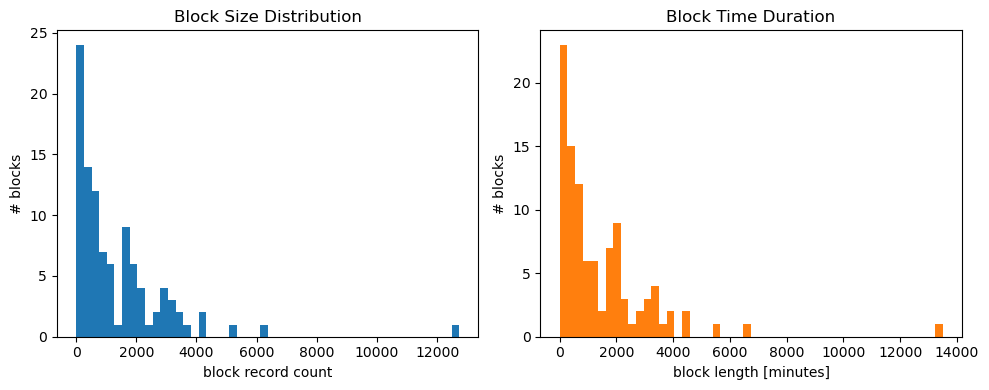

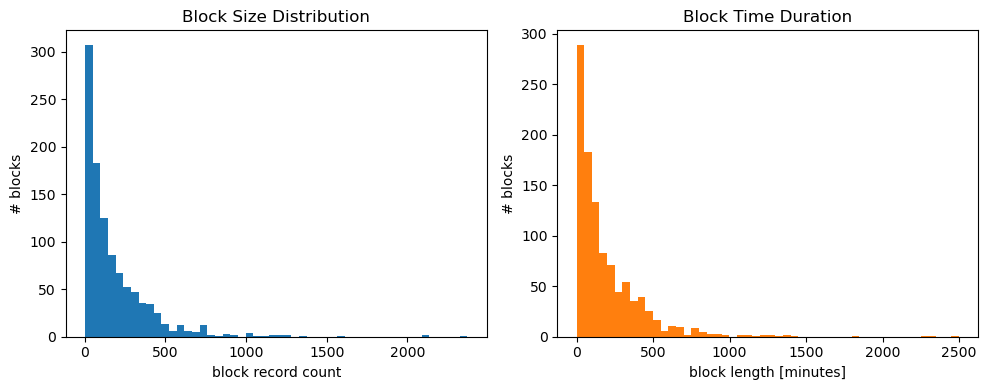

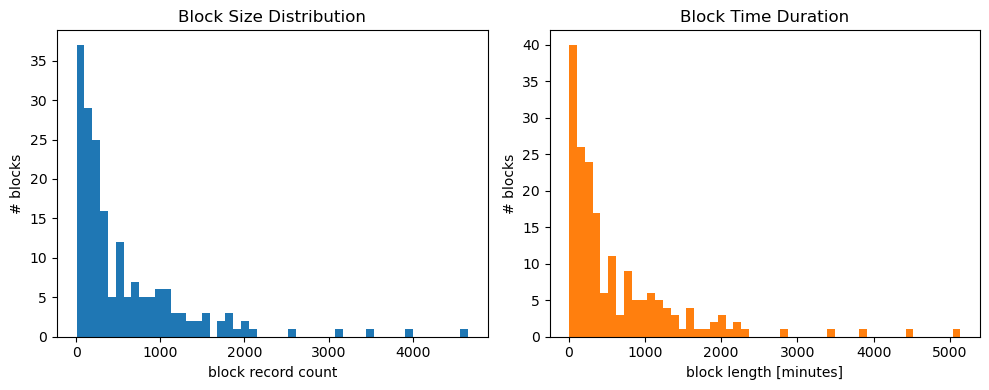

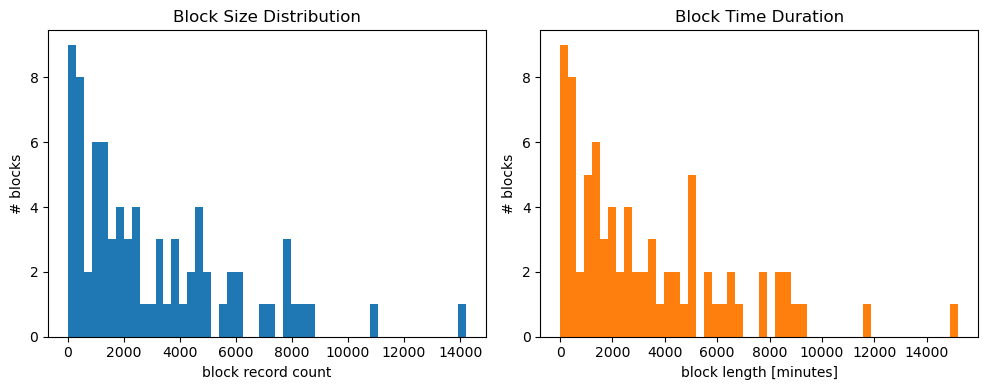

In [23]:
for hw in list_hw:

    print_separator(hw) #function to display a nice line separator with name
    dist_blocks = df_blocks.where(col("hwid")==hw).groupBy("BlockID").agg(count("*").alias("Block count")).orderBy("Block count")
    data = dist_blocks.toPandas()
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(data['Block count'], bins=50)
    axes[0].set_xlabel("block record count")
    axes[0].set_ylabel("# blocks")
    axes[0].set_title("Block Size Distribution")

    dist_blocks_min = (
        df_blocks.where(col("hwid") == hw)
        .groupBy("BlockID")
        .agg(((spark_max("when") - spark_min("when"))/60).alias("minutes"))
        .orderBy("minutes")
    )
    data = dist_blocks_min.toPandas()

    axes[1].hist(data['minutes'], bins=50, color = "#ff7f0e")
    axes[1].set_xlabel("block length [minutes]")
    axes[1].set_ylabel("# blocks")
    axes[1].set_title("Block Time Duration")
    

    plt.tight_layout()
    plt.show()

# Anomaly detection (1)

Each device in the dataset contains four different engines responsible for compressing gas to either chill or heat the environment. Continuously turning these engines ON and OFF at a high frequency is not recommended and could indicate problems during installation, deterioration of mechanical parts, or unsuitable external environmental conditions.

We define a column __flagAnomaly__ that is 1 when at least one of the four engines is experiencing an anomaly. The function is parallelized on each blockID (independent record between blocks), so we can inspect the anomalies found in the corresponding block.

## Distributed Analysis for Anomaly Detection

In [ ]:
def detect_anomalies(df, time_separator, threshold, sensors):

    # Partition data by BlockID. Underlying assumption is that data belonging to different blocks are not related.
    window = Window.partitionBy("BlockID").orderBy("when")

    # Forward-shift sensors'columns by 1 
    lagged_columns = [lag(col(s)).over(window) for s in sensors] 
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Determine if sensors switched (didSwitch = 1 if sensor goes from 1 to 0 or viceversa , didSwitch = 0 otherwise)
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect switchID: we assign an increasing ID to 'far enough' switching rows (by 'far enough' we mean 'distant at least time_separaor')
    # Notice: switchID is null for non-switching rows
    df_anomalies = df_didSwitch
    for sensor in sensors:   

        # Filter away non-switching rows / switching 1 not preceded by a 'close' 0 / switching 0 not followed by a 'close' 0 
        df_IDs = (
            df_didSwitch \
            .withColumn(f'theres0Before_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(1, time_separator)) > 0) \
            .withColumn(f'theres0After_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(-time_separator, -1)) > 0) \
            .filter( 
                (col(f'didSwitch_{sensor}') == 1) & 
                (when(col(sensor) == 1, col(f'theres0Before_{sensor}')).otherwise(True)) &
                (when(col(sensor) == 0, col(f'theres0After_{sensor}')).otherwise(True))
            ) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -1e9).over(window))>time_separator, 1).otherwise(0)) \
            .withColumn(f'switchID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(window)) \
        )
        
        # Add ID column to initial df
        df_anomalies = df_anomalies.join(
            other = df_IDs.select('BlockID', 'when', f'startGroup_{sensor}', f'switchID_{sensor}'),
            on = ['BlockID', 'when'],
            how = 'left'
        )

    # Count how many rows have the same switchID in each block
    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'switchID_{s}')) for s in sensors]

    # Determine anomaly flag: if there are more than 'threshold' rows with same ID (i.e. there are 'many' switches in a 'small' time) such row is an anomaly
    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') >= threshold) & (col(f'switchID_{s}') > 0), True).otherwise(False) for s in sensors]
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('BlockID', 'when')

    # Extend anomaly period: we classify as anomalies also non-switching rows comprised between equally-indexed anomaly-flagged rows (we expect anomalies to be exteneded-in-time) 
    # 1) Find the closest previous/posterior switchID if there is at least one with True flag anomaly.
    next_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(0, time_separator)
    prev_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(-time_separator, 0)

    prev_names = [f'prevID_{s}' for s in sensors]
    prev_id = [when((bool_or(f'flag_{s}').over(prev_w)), spark_max(f'switchID_{s}').over(prev_w)).otherwise(None) for s in sensors]
    next_names = [f'nextID_{s}' for s in sensors]
    next_id = [when((bool_or(f'flag_{s}').over(next_w)), spark_min(f'switchID_{s}').over(next_w)).otherwise(None) for s in sensors]

    df_newID = (
        df_flag \
            .withColumns(dict(zip(prev_names, prev_id))) \
            .withColumns(dict(zip(next_names, next_id)))
    )

    # 2) Check if next and previous indices coincide AND they are not 0/null.
    new_flags = [when((col(f'nextID_{s}') == col(f'prevID_{s}')) & (col(f'nextID_{s}') > 0), True).otherwise(col(f'flag_{s}')) for s in sensors]
    
    df_flag = df_newID.withColumns(dict(zip(flag_names, new_flags)))
    
    # Finally determine joint anomaly flag: if at least one of the sensors is anomalous, flag_anomaly=True
    condition = reduce(lambda a, b: a | b, [col(f'flag_{s}') for s in sensors])
    df_flag = df_flag.withColumn('flag_anomaly', when(condition, 1).otherwise(0))

    return df_flag \
        .select("BlockID", "when", *sensors, *flag_names, 'flag_anomaly') 

In [17]:
%%time

list_df_anomalies = {}
for hw in list_hw:
    df_anomalies = detect_anomalies(
        df = df_blocks.filter( col("hwid") == hw),
        time_separator = 60*40, # seconds
        threshold = 8,
        sensors = engines
    )

    list_df_anomalies[hw] = df_anomalies

CPU times: user 153 ms, sys: 46.4 ms, total: 200 ms
Wall time: 4.46 s


In [18]:
%%time

hw_to_inspect = 'SW-088'
list_df_anomalies[hw_to_inspect].filter('flag_S117').show(3, truncate=False)

+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|BlockID|when      |S117|S118|S169|S170|flag_S117|flag_S118|flag_S169|flag_S170|flag_anomaly|
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|71     |1602481950|1   |0   |1   |1   |true     |false    |true     |false    |1           |
|71     |1602482010|1   |0   |0   |1   |true     |false    |true     |false    |1           |
|71     |1602482070|0   |0   |0   |1   |true     |false    |true     |false    |1           |
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
only showing top 3 rows

CPU times: user 6.5 ms, sys: 6.88 ms, total: 13.4 ms
Wall time: 6.44 s


In [ ]:
print("Know some BlockID where there are anomalies, so we can plot it and see.")

BlockWithAnom = list_df_anomalies[hw_to_inspect].filter('flag_S117').select('BlockID').distinct().orderBy('BlockID')
listBlockAnom = BlockWithAnom.collect()

Know some BlockID where there are anomalies, so we can plot it and see.


We want to inespect the anomalies detected in some of the blocks in order to understand how they are made (given the engines, in this case the S177). <br>
The plot shows 
* __ON THE RIGHT__ a specific block where it is shown when the engines is ON (value 1) or OFF (value 0). The orange interval is the interval the algorithm flags as anomaly.

* __ON THE LEFT__ the same block but __Remembering that the number of record in a block usually does not correspond to the time elapsed in a block since there might be empty interval__: the red bars correspond to the empty intervals (where there are no data)

In [20]:
def inspect_anomalies(df, sensor, blockID):
    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()
    def extract_when(df):
        return df.filter(col('BlockID') == blockID) \
            .select('when') \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, sensor, 0)
    anomalies = extract_column(df, f'flag_{sensor}', False)
    whens     = extract_when(df)

    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    t_min, t_max = min(whens), max(whens)
    full_t = list(range(t_min, t_max + 60, 60))
    full_t_rel = [(t - t_min) // 60 for t in full_t]
    whens_rel  = [(w - t_min) // 60 for w in whens]
    values_map    = dict(zip(whens_rel, values))
    anomalies_map = dict(zip(whens_rel, anomalies))
    aligned_values    = [values_map.get(t, 0) for t in full_t_rel]
    aligned_anomalies = [anomalies_map.get(t, 0) for t in full_t_rel]
    missing = [0.5 if t not in whens_rel else 0 for t in full_t_rel]
    combined_anomalies = [max(a, m) for a, m in zip(aligned_anomalies, missing)]

    axes[0].bar(full_t_rel, aligned_values, width=1, alpha=0.7, color="blue", label=sensor)
    axes[0].bar(full_t_rel, missing, width=1, alpha=0.8, color="red", label="time hole")
    axes[0].bar(full_t_rel, combined_anomalies, width=1, alpha=0.5, color="orange", label="anomal")
    axes[0].set_xlabel("Minutes (relative to block start)")
    axes[0].set_ylabel(sensor)
    axes[0].legend(loc='lower right')
    axes[0].set_title(f"Block N.{blockID} (raw)")

    t = range(len(anomalies))
    axes[1].bar(t, values, width=1, alpha=0.5, lw=1)
    axes[1].bar(t, anomalies, width=1, alpha=0.5, label="anomal")
    axes[1].set_xlabel("Consecutive available data")
    axes[1].set_ylabel(sensor)
    axes[1].legend(loc='lower right')
    axes[1].set_title(f"Block N.{blockID} (aligned)")

    plt.tight_layout()
    plt.show()

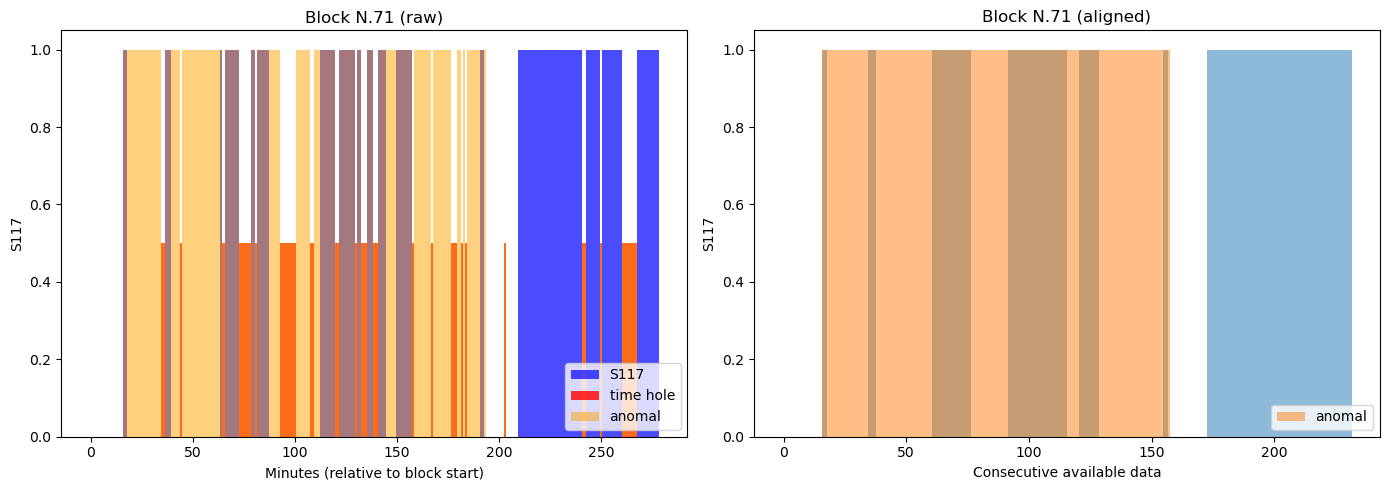

In [29]:
for row in listBlockAnom[:1]:
    inspect_anomalies(list_df_anomalies[hw_to_inspect], 'S117', row[0])

In [21]:
# Join on `when` and take just `flag_anomaly`

list_df_blocks_anom = {}

for hw in list_hw:
    df_anom = list_df_anomalies[hw].select('when', 'flag_anomaly')
    list_df_blocks_anom[hw] = df_blocks.filter( col("hwid") == hw ).join( df_anom, on='when', how='left' )

## Linear correlation setup (used for anomalies, S125-S181, A5-A9)

Computing the correlations between metrics using the already implemented __corr__ function.

In [9]:
def correlations(df, sensors_list, target_col, batch_size=25): 
    all_correlations = []
    
    # Process sensors in batches to avoid broadcasting large tasks
    for i in range(0, len(sensors_list), batch_size):
        batch_sensors = sensors_list[i:i + batch_size]
        
        # Create correlation expressions for current batch
        corr_expressions = [corr(target_col, sensor).alias(f"corr_{sensor}") for sensor in batch_sensors]
        
        # Execute correlations for this batch
        batch_results = df.agg(*corr_expressions).collect()[0]
        
        # Extract correlation values (handle nulls as 0.0)
        batch_correlations = [batch_results[f"corr_{sensor}"] or 0.0 
                            for sensor in batch_sensors]
        all_correlations.extend(batch_correlations)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        "Sensors": sensors_list, 
        "Correlations": all_correlations
    })
    
    # Sort by absolute correlation (highest first)
    sorted_results = results_df.reindex(
        results_df["Correlations"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    
    return sorted_results

In [10]:
def plot_correlations(df_spark, target_col, feature_cols, corr_df, hw):
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_str = f"{corr_val[0]:.3f}" if len(corr_val) > 0 else "N/A"
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.scatter(pd_df[feature], pd_df[target_col], color="steelblue", alpha=0.005)
        ax1.set_ylabel(target_col)
        
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax2.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        ax2.set_ylabel("Density")
        ax2.legend()
        
        fig.suptitle(f"{hw} - {feature} - Correlation: {corr_str}")
        plt.tight_layout()
        plt.show()

## Correlation Analysis for Anomalies

Showing the most anomaly-correlated distribution among all metrics.

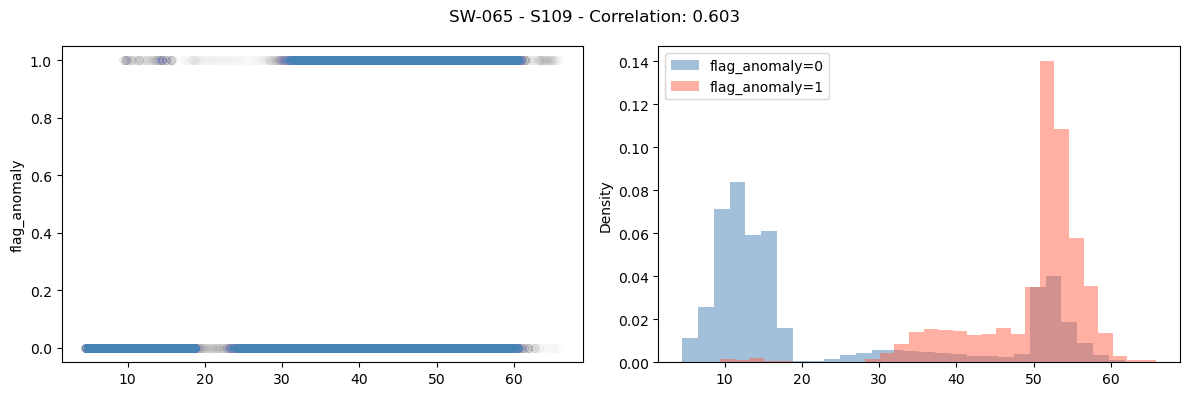

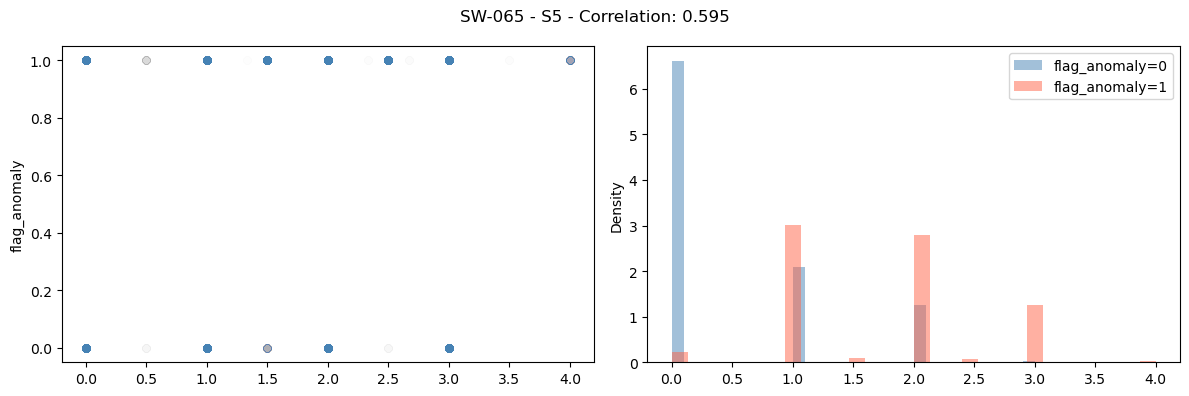

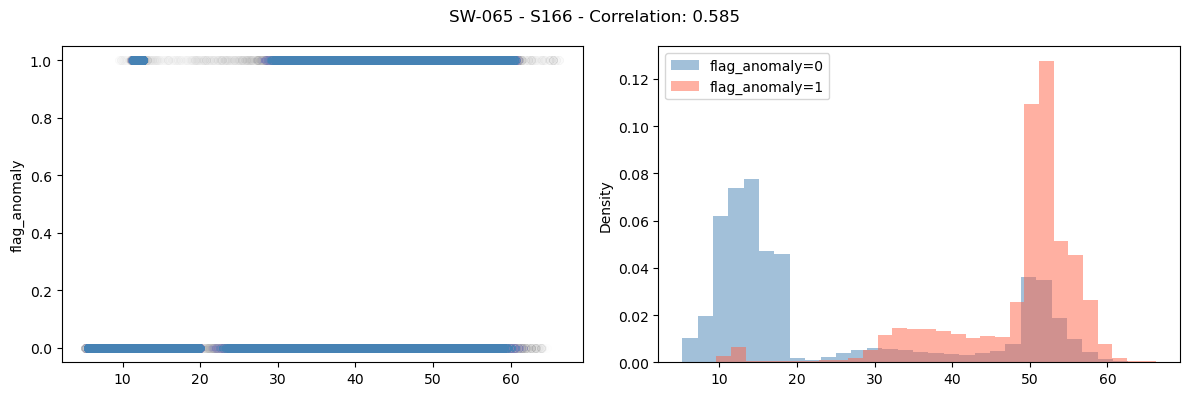

ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [33]:
%%time

for hw in list_hw:

    print_separator(hw)
    anomaly_corr = correlations(list_df_blocks_anom[hw], useful_sensors, 'flag_anomaly')
    top_anom_corr = anomaly_corr.head(3)['Sensors'].tolist()
    plot_correlations(list_df_blocks_anom[hw], 'flag_anomaly', top_anom_corr, anomaly_corr, hw)

## Alternative approach: Random Forest 

In [41]:
#Model the training set balancing the flag anomalies ratio
hw = 'SW-088'

df_final_flag0 = df_all_hw.filter(col('flag_anomaly')==0)
df_final_flag1 = df_blocks.filter(col('flag_anomaly')==1)

to_drop_df = df_final_flag0.sample(withReplacement = False, fraction = 0.85, seed = 2503)

df_final_flag0_reduced = df_final_flag0.subtract(to_drop_df)

df_final_balanced = df_final_flag1.union(df_final_flag0_reduced)


#Check for the ratio between the flag anomalies 1 and 0
flag_ratio = df_final_balanced.filter(col('flag_anomaly')==1).count()/df_final_balanced.filter(col('flag_anomaly')==0).count()

print("Ratio [1/0]:",flag_ratio)

25/08/24 16:16:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `flag_anomaly` cannot be resolved. Did you mean one of the following? [`ComError`, `when`, `A5`, `A9`, `BlockID`].;
'Filter ('flag_anomaly = 0)
+- Project [hwid#0, when#1L, window_start#2, window_end#3, A5#284, A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, ... 90 more fields]
   +- Project [hwid#0, when#1L, window_start#2, window_end#3, A5#284, cast(A9#5 as int) AS A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, ... 118 more fields]
      +- Project [hwid#0, when#1L, window_start#2, window_end#3, cast(A5#4 as int) AS A5#284, A9#5, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, ... 118 more fields]
         +- Relation [hwid#0,when#1L,window_start#2,window_end#3,A5#4,A9#5,ComError#6,P1#7,P10#8,P15#9,P16#10,P17#11,P18#12,P2#13,P5#14,P6#15,P7#16,P8#17,P9#18,S1#19,S10#20,S100#21,S101#22,S102#23,... 118 more fields] parquet


In [37]:
def run_random_forest(df, feature_cols, label_col="label", n_trees=100, max_depth=5, test_fraction=0.2, seed = 2503):
    
    train_df, test_df = df.randomSplit([1 - test_fraction, test_fraction], seed=seed)
    print(f"Training on {train_df.count()} rows, testing on {test_df.count()} rows")
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    rf = RandomForestClassifier(labelCol=label_col, featuresCol="features", numTrees=n_trees, maxDepth=max_depth,  seed=seed)

    pipeline = Pipeline(stages=[assembler, rf]) #La pipeline serve per dire a Spark di eseguire due operazioni consecutive, poi Spark si arrangia a gestirle in questo modo

    model = pipeline.fit(train_df) 

    train_predictions = model.transform(train_df)
    test_predictions = model.transform(test_df)

    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    test_accuracy = evaluator.evaluate(test_predictions)

    print(f"RandomForest trained with {n_trees} trees, maxDepth={max_depth}")
    print(f"Test Accuracy = {test_accuracy:.4f}")

    rf_model = model.stages[-1] 
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(feature_cols, importances), key=lambda x: -x[1])

    print("\nFeature Importances:")
    for col, imp in feature_importance:
        print(f"{col}: {imp:.4f}")

    return model, train_predictions, test_predictions, test_accuracy

In [38]:

useful_sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA2', 'SA3', 'SA5', 'SA6', 'SA7', 'SA9']

In [39]:
%%time

vector_to_drop = ['A5', 'A9', 'ComError', 'overheating']

sensors_forest = [s for s in useful_sensors if s not in vector_to_drop]

model, train_preds, test_preds, test_accuracy = run_random_forest(df_final_balanced, feature_cols=sensors_forest, label_col="flag_anomaly", n_trees = 120, max_depth = 10, test_fraction=0.33333)

test_preds.select('flag_anomaly', 'prediction', 'probability').show(10, truncate = 0)

Training on 32293 rows, testing on 16225 rows


IllegalArgumentException: P1 does not exist. Available: BlockID, when, S117, S118, S169, S170, flag_S117, flag_S118, flag_S169, flag_S170, flag_anomaly

In [40]:
#Prediction with the obtained model
n = 20
data_row = df_final_balanced.orderBy(rand()).limit(n)

predicted_data = model.transform(data_row)
predicted_data.select("S109", "S166", "S102", "flag_anomaly", "prediction").show()

NameError: name 'model' is not defined

# Anomaly Detection (2)

Each device in the dataset contains four different engines. The percentage of working/loading of these units is crucial as it can indicate issues related to under-dimensioned or over-dimensioned devices, deterioration of mechanical parts, or unsuitable external environmental conditions. Here we identify possible correlations between the percentage of device loading (__S125__, __S181__) and the external temperature (__S41__). 

## Correlation between device load and external temperature (S125-S181 vs S41)

In [ ]:
%%time

load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

for hw in list_hw:
    print_separator(hw)
    temper_corr = correlations(list_df_blocks_anom[hw], load_sensors, temperature_sensor)

    plot_correlations(list_df_blocks_anom[hw], temperature_sensor, load_sensors, temper_corr, hw)

Showing the joint distribution of temperature (__S41__) and percentage work load (__S125__, __S181__).

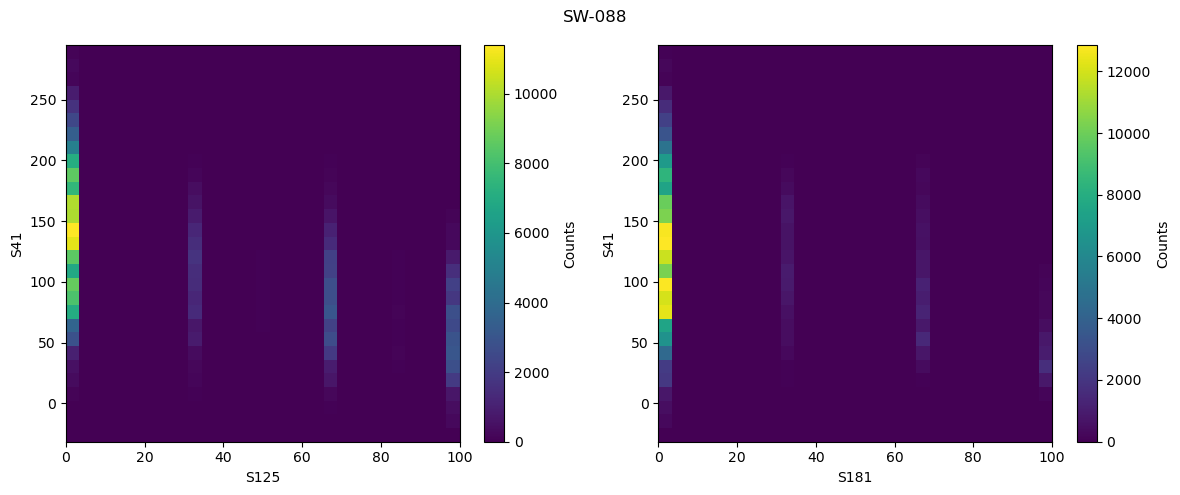

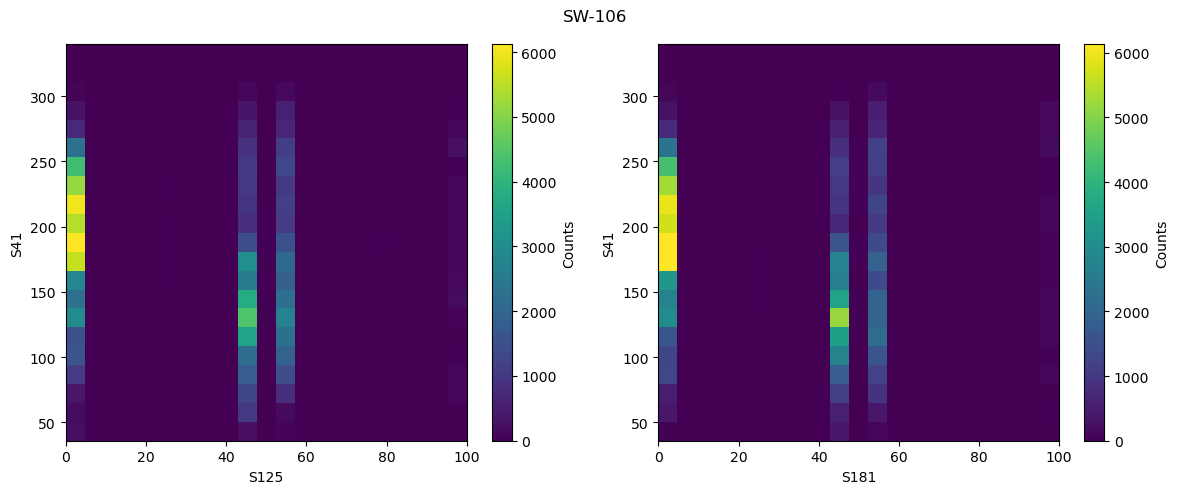

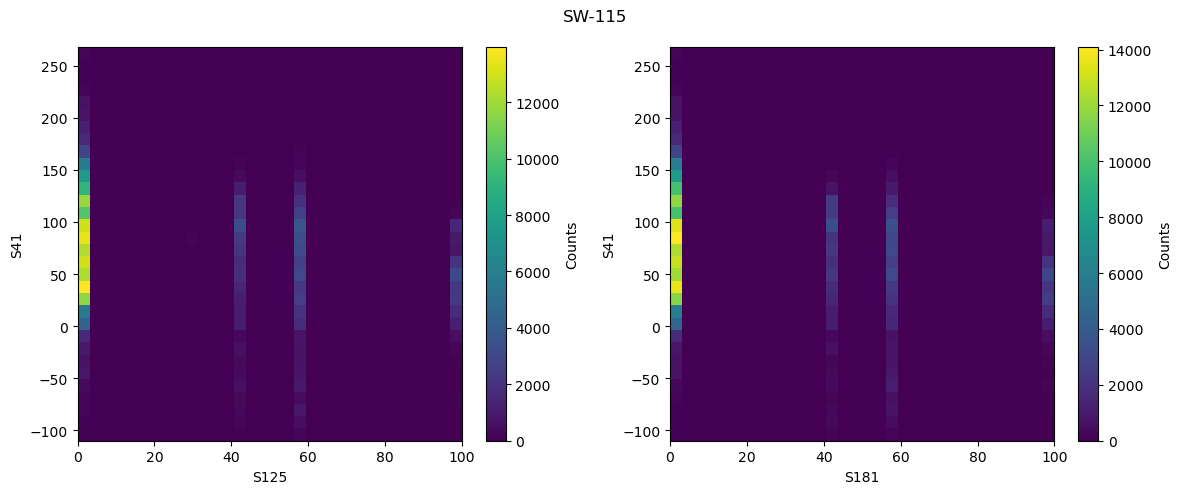

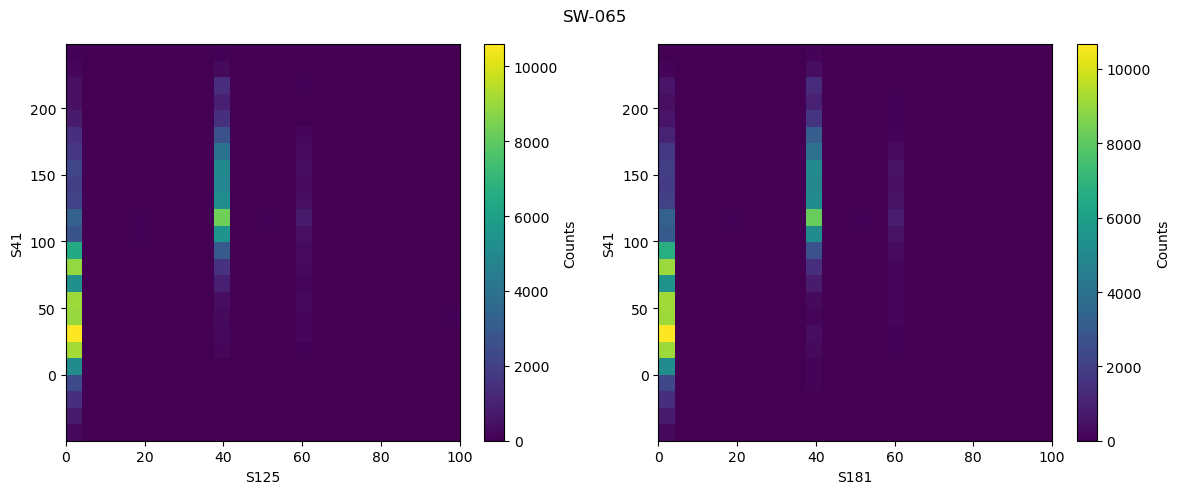

In [ ]:
load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

for hw in list_hw:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    # fig.subplots_adjust(wspace=0.4)
    fig.suptitle(f"{hw}")
    
    for i in range(len(load_sensors)):
        load_sensor = load_sensors[i]
        filtered_df = list_df_blocks_anom[hw].dropna(subset=(temperature_sensor, load_sensor))
        
        temperature = filtered_df.select(temperature_sensor).rdd.flatMap(lambda x: x).collect()
        load        = filtered_df.select(load_sensor).rdd.flatMap(lambda x: x).collect()
        bins = int(np.sqrt(len(temperature))/15)
        
        counts, xedges, yedges, im = ax[i].hist2d(load, temperature, bins=bins)
        cbar = fig.colorbar(im, ax=ax[i])   
        cbar.set_label('Counts')  
        ax[i].set_ylabel(temperature_sensor)
        ax[i].set_xlabel(load_sensor)
        
    plt.tight_layout()    
    plt.show()

Plotting the distribution of the temperature when fixing the percentage work load (x-slicing of the above picture). <br>
We show the temperature distributions for the 3 most correlated values of each sensor. As expected, we see a trend coherent with the thermodynamics of heat pumps: when the average temperature increases, the work load is smaller.


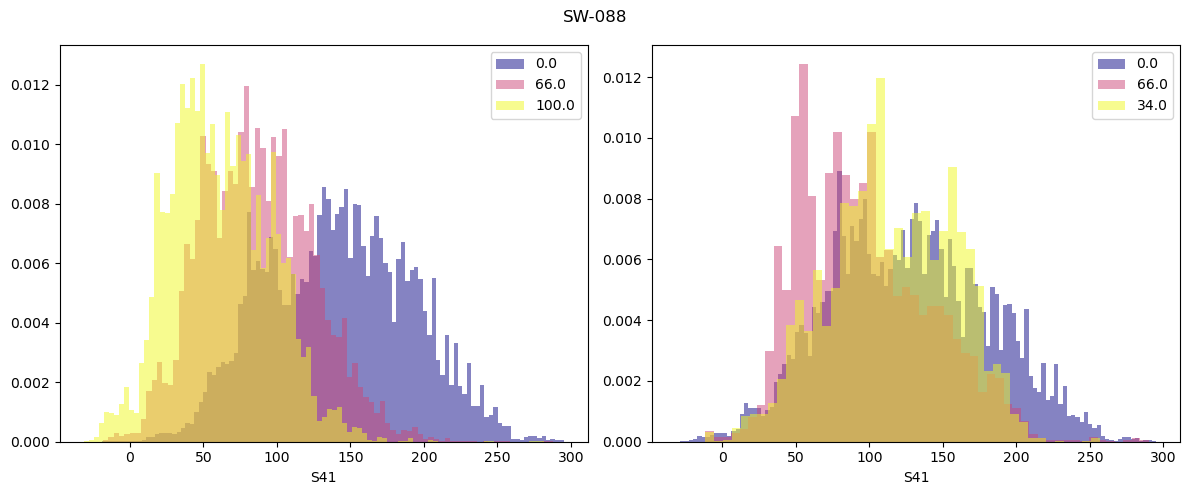

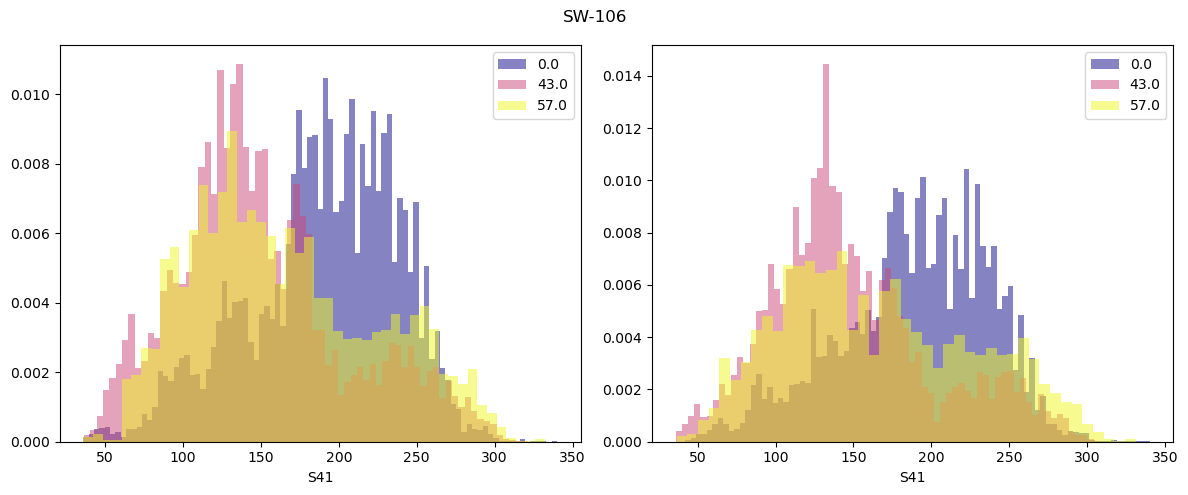

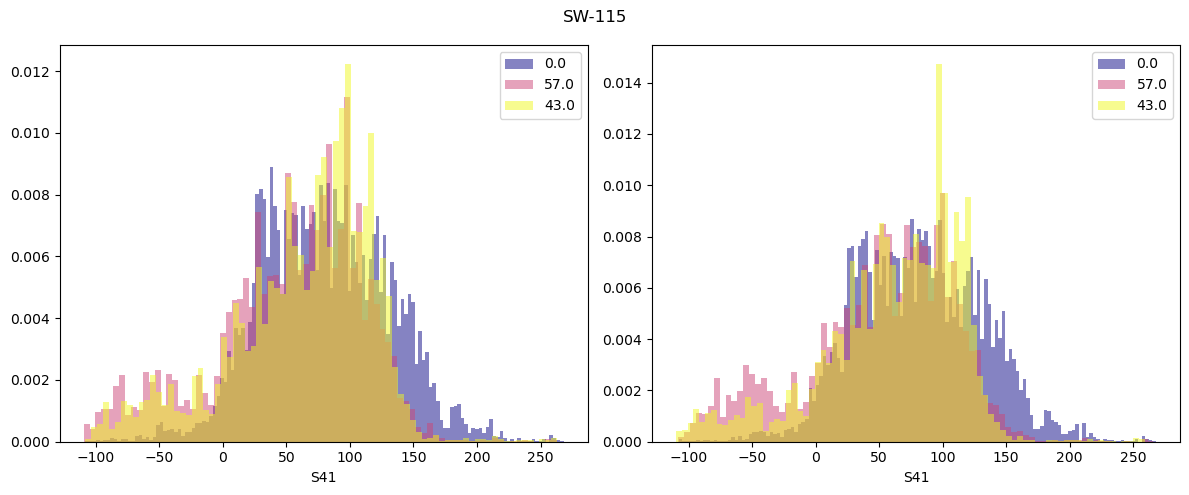

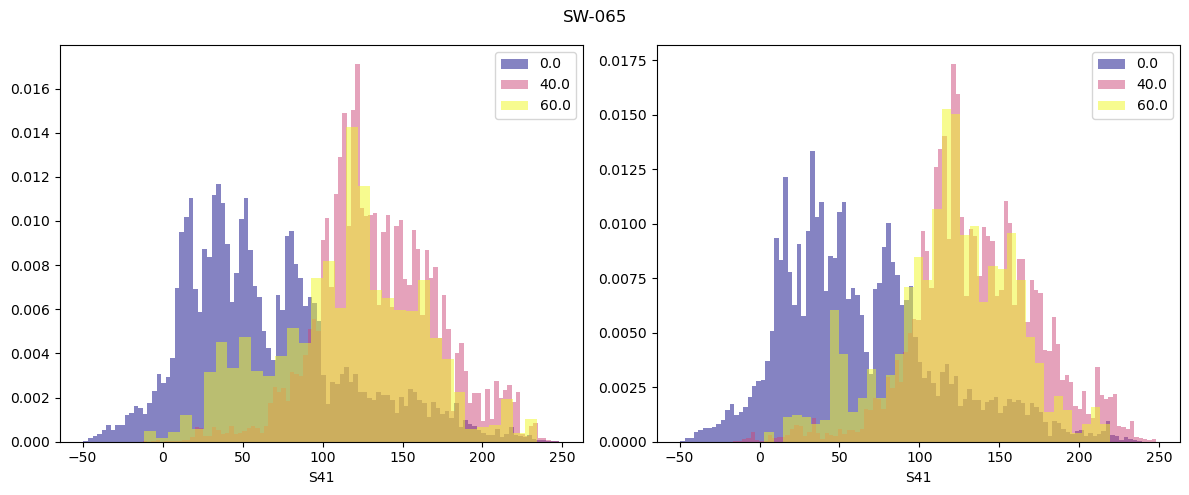

CPU times: user 3.91 s, sys: 178 ms, total: 4.08 s
Wall time: 49.6 s


In [18]:
%%time

# Inspect overlap of temperature distributions for different work load percentages

n_distributions = 3 # Show the first n most numerous distributions

for hw in list_hw:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{hw}")
    
    for i in range(len(load_sensors)):
        load_sensor = load_sensors[i]
        noNull_df = list_df_blocks_anom[hw].dropna(subset=(temperature_sensor, load_sensor))

        top_load_percentages = noNull_df \
            .select(load_sensor) \
            .groupBy(load_sensor) \
            .count() \
            .sort('count', ascending=False) \
            .limit(n_distributions) \
            .select(load_sensor) \
            .rdd.flatMap(lambda x: x) \
            .collect()
        # In alternativa, se lento fare pivot intorno a load_sensor dopo il filtro
        # print(load_sensor, ': ', top_load_percentages)
        
        cmap = plt.get_cmap('plasma') # viridis, plasma
        colors = [cmap(i) for i in np.linspace(0, 1, n_distributions)]

        for load_percentage, color in zip(top_load_percentages, colors): 
            temperature = noNull_df \
                .filter(f'{load_sensor} = {load_percentage}') \
                .select(temperature_sensor) \
                .rdd.flatMap(lambda x: x) \
                .collect()
            # bins = int(np.sqrt(len(temperature))/2)
            
            ax[i].hist(temperature, bins='auto', color=color, alpha=0.5, label=f'{load_percentage}', density=True)  
            ax[i].set_xlabel(temperature_sensor)
            ax[i].legend()
            
    plt.tight_layout()    
    plt.show()

# Predictive maintenance

This section aims to build a model using simple machine learning techniques and specific adjustments to predict—and ideally prevent—overheating alerts. <br> The process begins by analyzing data related to A5 and A9 alarms.

## Conversion of Alarms (A5, A9)

Variables A5 and A9 contain alarms related to the devices. <br>
Specifically, if one or more of the bits in positions 6, 7, and 8 of either or both alarms are equal to 1, it indicates a fault. If at least one of these bits is set to 1, it signifies that the engines are overheating.

Among the four hardware units, only SW-088 recorded overheating signals (124), some of which occurred consecutively or within short intervals as we will see in the following parts, likely indicating repeated alerts for the same issue.

In [24]:
def extract_alarms(df):

    columns=["A5", "A9"]
    bits=[6, 7, 8]
    
    for col_name in columns:
        for bit in bits:
            convert_bit = bit - 1  # bit 1 is LSB
            df = df.withColumn( f"{bit}-{col_name}", ((col(col_name).bitwiseAND(1 << convert_bit)) > 0).cast("int") )

    df = df.withColumn(
        "overheating",
        when((col("6-A5") == 1) | (col("7-A5") == 1) | (col("8-A5") == 1) | (col("6-A9") == 1) | (col("7-A9") == 1) | (col("8-A9") == 1) ,
            1).otherwise(0).cast("int")
            ).where( (col("A5").isNotNull()) | (col("A9").isNotNull()) )
    
    return df

In [25]:
# Extract bits from alarms

list_df_alarms = {}
for hw in list_hw:
    df_alarms = extract_alarms( df_blocks.filter( col("hwid") == hw).select("when","A5","A9") )

    list_df_alarms[hw] = df_alarms
    print( f"For hardware {hw} were recorded {df_alarms.agg(spark_sum(col('overheating'))).collect()[0][0]} overheating signals." )

list_df_alarms['SW-088'].where( col("overheating") == 1 ).show(10)

For hardware SW-115 were recorded 0 overheating signals.
For hardware SW-088 were recorded 124 overheating signals.
For hardware SW-065 were recorded 0 overheating signals.
For hardware SW-106 were recorded 0 overheating signals.
+----------+-----+----+----+----+----+----+----+----+-----------+
|      when|   A5|  A9|6-A5|7-A5|8-A5|6-A9|7-A9|8-A9|overheating|
+----------+-----+----+----+----+----+----+----+----+-----------+
|1601510790|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601510850|18496|NULL|   0|   1|   0|NULL|NULL|NULL|          1|
|1601597190|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601597250|18496|NULL|   0|   1|   0|NULL|NULL|NULL|          1|
|1601686290|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601686350|18496|NULL|   0|   1|   0|NULL|NULL|NULL|          1|
|1601769750|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601856330|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601856390|18496|NULL|   0|   1|   0|NULL|N

In [26]:
%%time

list_df_final = {}

for hw in list_hw:
    df_final = list_df_blocks_anom[hw].join( list_df_alarms[hw].select('when', 'overheating') , on='when', how='left' )
    list_df_final[hw] = df_final

CPU times: user 4.24 ms, sys: 824 μs, total: 5.07 ms
Wall time: 323 ms


## Correlation analysis for alarms

In [ ]:
# the only one in which there is overheating
df_final_088 = list_df_final['SW-088']

# in order to remove NULL
df_final_088 = df_final_088.withColumn("overheating", coalesce(col("overheating"), lit(0)))

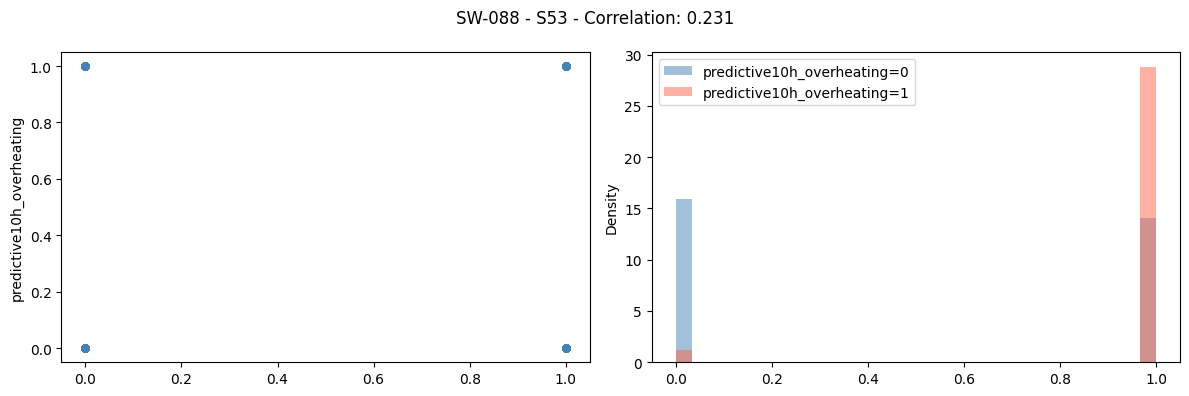

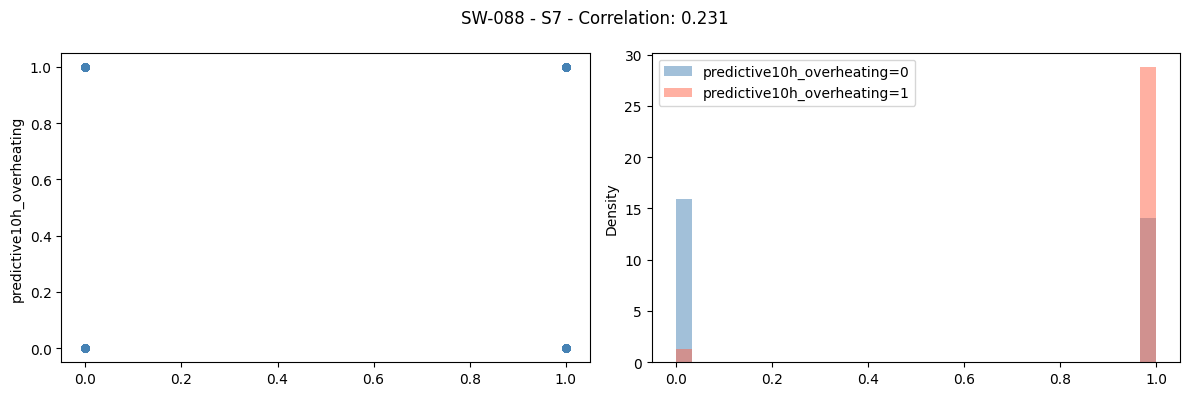

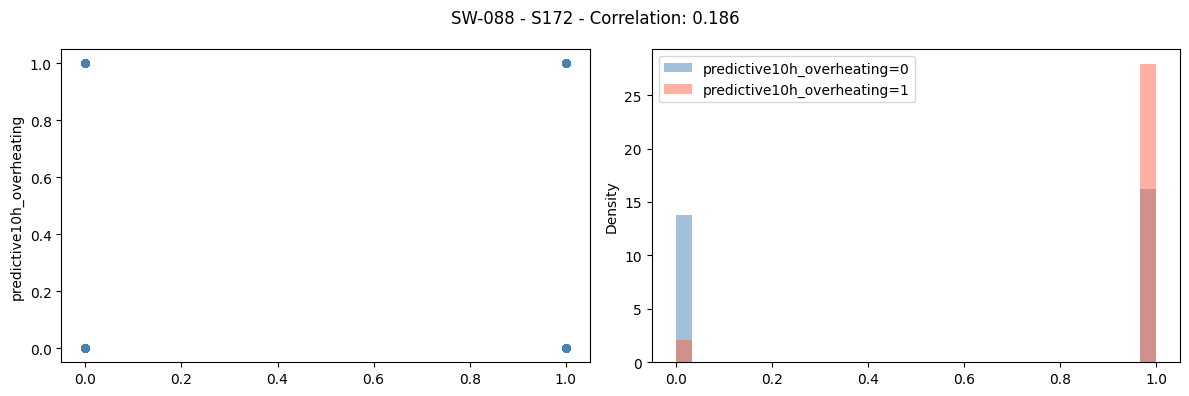

In [48]:
alarm_corr = correlations(df_final_088, useful_sensors, 'overheating')
top_alarm_corr = alarm_corr.head(3)['Sensors'].tolist()
plot_correlations(df_final_088, 'overheating', top_alarm_corr, alarm_corr, 'SW-088')
sensors = alarm_corr["Sensors"]
correlations = alarm_corr["Correlations"]

# Predictive modeling 

## Add predictive flag

A new column named __predictive_overheating__ is added for predictive maintenance, flagging with 1 all data points within 30 minutes prior to an overheating signal (note that this structure can also be applied to anomaly-related flags). The 30-minute threshold is arbitrary and considered a tunable hyperparameter.

In [45]:
def add_predictive(df, target, window_before=30, join=True ,debug=False): #window_before in minutes

    w = Window.partitionBy("BlockID").orderBy("when")

    df_pred = df.select("BlockID","when","window_start",target)
    df_pred = df.withColumn(f"prev_{target}", lag(target).over(w))
    df_pred = df_pred.withColumn(
        f"is_start_{target}",
        when(
            (col(target) == 1) &
            ((col(f"prev_{target}") != 1) | col(f"prev_{target}").isNull()),
            1
        ).otherwise(0)
    )

    df_pred = df_pred.withColumn(f"start_time_{target}", when(col(f"is_start_{target}") == 1, col("when")))

    w_future = w.rowsBetween(Window.currentRow, Window.unboundedFollowing)
    df_pred = df_pred.withColumn(
        f"next_start_{target}",
        first(f"start_time_{target}", ignorenulls=True).over(w_future)
    )

    window_seconds = window_before * 60
    df_pred = df_pred.withColumn(
    f"predictive_{target}",
        when(
            (col(f"next_start_{target}").isNotNull()) &
            (((col(target).isNull()) | (col(target) == 0))) &
            ((col(f"next_start_{target}") - col("when")) > 0) &
            ((col(f"next_start_{target}") - col("when")) <= window_seconds), 1 ).otherwise(0))

    if not debug:
        df_pred = df_pred.select("BlockID","when",target,f"predictive_{target}")


    if join:
        return df.join( df_pred.select('when', f'predictive_{target}') , on='when', how='left' )
    else:
        return df_pred

In [34]:
target = "overheating"
df_final_088 = add_predictive(df_final_088, target, window_before=30, debug=False, join=True )

target = "flag_anomaly"
df_final_088 = add_predictive(df_final_088, target, window_before=30, debug=False, join=True )

In [15]:
# Example of "predictive flag"

target = "overheating"
df_final_088.where( (col("when") >= 1611963630) & (col("when") <= 1611965670) ).orderBy(col("when").asc()) \
     .select("when","window_start",target,f"predictive_{target}") .show(50)

+----------+-------------------+-----------+----------------------+
|      when|       window_start|overheating|predictive_overheating|
+----------+-------------------+-----------+----------------------+
|1611963630|2021-01-29 23:40:00|          0|                     0|
|1611963690|2021-01-29 23:41:00|          0|                     0|
|1611963750|2021-01-29 23:42:00|          0|                     1|
|1611963810|2021-01-29 23:43:00|          0|                     1|
|1611963870|2021-01-29 23:44:00|          0|                     1|
|1611963930|2021-01-29 23:45:00|          0|                     1|
|1611963990|2021-01-29 23:46:00|          0|                     1|
|1611964050|2021-01-29 23:47:00|          0|                     1|
|1611964110|2021-01-29 23:48:00|          0|                     1|
|1611964170|2021-01-29 23:49:00|          0|                     1|
|1611964230|2021-01-29 23:50:00|          0|                     1|
|1611964290|2021-01-29 23:51:00|          0|    

Recomputing correlations between data near overheating events and the full dataset yields results consistent with those obtained using only overheating signals. It's important to note the strong class imbalance, with the dataset being overwhelmingly composed of data labeled as 'normal'.

In [ ]:
alarm_corr = correlations(df_final_088, useful_sensors, 'predictive_overheating')
top_alarm_corr = alarm_corr.head(3)['Sensors'].tolist()
plot_correlations(df_final_088, 'predictive_overheating', top_alarm_corr, alarm_corr, 'SW-088')

In [27]:
normal_count = df_final_088.filter( 'predictive_overheating=0' ).count()
predictive_count = df_final_088.filter( 'predictive_overheating=1' ).count()
print(
    f"Data are divided into two classes:\n"
    f" 0: normal\t\twith {normal_count} data \t({normal_count / (normal_count + predictive_count):.1%})\n"
    f" 1: before overheating\twith {predictive_count}   data \t({predictive_count / (normal_count + predictive_count):.1%})\n"
)

Data are divided into two classes:
 0: normal		with 189979 data 	(99.0%)
 1: before overheating	with 1826   data 	(1.0%)



## Blocks between alarms signals

Following a conceptually similar approach to the creation of BlockID, a new grouping flag called __BlockHeat__ is introduced. <br> This flag uniquely identifies consecutive data segments that span from one alarm signal to the next (continuous '1's in the overheating signal are discarded).

In [28]:
def add_heat_blocks(df, minBlockLength=2, debug=True):

    w = Window.partitionBy( lit(0).alias("auxiliary") ).orderBy("when")

    df = df.withColumn("new_block_flag", when(lag("overheating", 1).over(w) == 1, lit(1)).otherwise(lit(0)))
    df = df.withColumn("oldBlockHeat", spark_sum("new_block_flag").over(w) + lit(1)) #old cause some blocks will be eliminated
    
    
    # delete last BlockHeat if there is no overheating in it
    last_row = df.orderBy(col("when").desc()).first()
    last_heating_value = last_row["overheating"]
    last_BlockHeat = last_row["oldBlockHeat"]
    if last_heating_value != 1:
        df = df.where(col("oldBlockHeat") < last_BlockHeat)

    block_counts = df.groupBy("oldBlockHeat").count().filter(col("count") >= minBlockLength)
    df = df.join(block_counts.select("oldBlockHeat"), on="oldBlockHeat", how="inner") # inner join to retain only block a with sufficient length

    w = Window.partitionBy("oldBlockHeat").orderBy("when")
    # rename in order the blocks after we applyed the filter
    distinct_blocks = df.select("oldBlockHeat").distinct().orderBy("oldBlockHeat") \
                        .withColumn("BlockHeat", row_number().over(Window.orderBy("oldBlockHeat")))
    df = df.join(distinct_blocks, on="oldBlockHeat", how="left")

    # create column for time relative to overheating
    w = Window.partitionBy("BlockHeat").orderBy("when")
    overheat_times = ( df.groupBy("BlockHeat").agg(spark_max("when").alias("TimeOverheating")) )
    df = df.join(overheat_times, on="BlockHeat", how="left")
    df = df.withColumn( "MinToOverheating",( col("TimeOverheating")-col("when") ) / 60 )

    if debug:
        return df.orderBy("when")
    else:
        return df.drop("new_block_flag", "oldBlockHeat", "TimeOverheating").orderBy("when")

In [29]:
# just removing double 1,1 signals
df_maintenance = add_heat_blocks( df_final_088, minBlockLength=2, debug=True )

In [33]:
# example with full debug table
df_maintenance.where( (col("when")<=1601511030) & (col("when")>=1601510490) )\
.select("when","window_start","overheating","oldBlockHeat","BlockHeat","new_block_flag","TimeOverheating","MinToOverheating")\
.orderBy(col("when").asc()).show(10)

+----------+-------------------+-----------+------------+---------+--------------+---------------+----------------+
|      when|       window_start|overheating|oldBlockHeat|BlockHeat|new_block_flag|TimeOverheating|MinToOverheating|
+----------+-------------------+-----------+------------+---------+--------------+---------------+----------------+
|1601510490|2020-10-01 00:01:00|          0|           1|        1|             0|     1601510790|             5.0|
|1601510550|2020-10-01 00:02:00|          0|           1|        1|             0|     1601510790|             4.0|
|1601510610|2020-10-01 00:03:00|          0|           1|        1|             0|     1601510790|             3.0|
|1601510670|2020-10-01 00:04:00|          0|           1|        1|             0|     1601510790|             2.0|
|1601510790|2020-10-01 00:06:00|          1|           1|        1|             0|     1601510790|             0.0|
|1601510910|2020-10-01 00:08:00|          0|           3|        2|     

In [57]:
grouped_blocks = df_maintenance.groupBy("BlockHeat").count().orderBy(col("count").desc())

range_blocks = grouped_blocks.withColumn(
    "Block size (rows)",
    when(col("count").between(1, 30), "1-30")
    .when(col("count").between(31, 100), "31-100")
    .when(col("count").between(101, 500), "101-500")
    .when(col("count").between(501, 1000), "501-1000")
    .when(col("count").between(1001, 1500), "1001-1500")
    .when(col("count").between(1501, 2000), "1501-2000")
    .when(col("count").between(2001, 4000), "2001-4000")
    .when(col("count") > 4000, ">4000")
    .otherwise("Other")
)

range_blocks_grouped = range_blocks.groupBy("Block size (rows)").agg(count("*").alias("How many blocks"))\
    .orderBy(
        when(col("Block size (rows)") == "1-30", 1)
        .when(col("Block size (rows)") == "31-100", 2)
        .when(col("Block size (rows)") == "101-500", 3)
        .when(col("Block size (rows)") == "501-1000", 4)
        .when(col("Block size (rows)") == "1001-1500", 5)
        .when(col("Block size (rows)") == "1501-2000", 6)
        .when(col("Block size (rows)") == "2001-4000", 7)
        .when(col("Block size (rows)") == ">4000", 8)
        .otherwise(8)
    )

range_blocks_grouped.show()

+-----------------+---------------+
|Block size (rows)|How many blocks|
+-----------------+---------------+
|             1-30|             15|
|           31-100|              5|
|          101-500|             14|
|         501-1000|             20|
|        1001-1500|             32|
|        2001-4000|              4|
|            >4000|              3|
+-----------------+---------------+



## Sensors behavior

To predict future faults, it is essential to analyze the behavior of the sensors most correlated with overheating fenomena. <br> To do this, we used the newly created block structure to aggregate sensor data based on the time at which it was acquired relative to the upcoming alarm signal. This allows us to compute, for each sensors, metrics such as count, mean, and error. <br> Most importantly, we calculate a time-based moving average,referred to as __rolling__, for each point by looking backward within the block over a defined time window (we selected 4 hours, another model hyperparameter). This helps extract a smoother trend, less affected by short-term fluctuations.

In [49]:
def info_overheating(df, duration, sensors, rolling):
    
    df = df.filter(col("MinToOverheating") <= duration)

    aggs = []
    for s in sensors:
        aggs.append(spark_avg(col(s)).alias(f"{s}_avg"))
        aggs.append(spark_stddev(col(s)).alias(f"{s}_std"))
        aggs.append(count(col(s)).alias(f"{s}_n"))
    
    df_summary = df.groupBy("MinToOverheating").agg(*aggs)
    
    w = Window.partitionBy(lit(0)).orderBy("MinToOverheating")
    
    for s in sensors:
        df_summary = df_summary.withColumn(f"{s}_rolling", spark_avg(f"{s}_avg").over(w.rangeBetween(-rolling, 0)) )
        df_summary = df_summary.withColumn(f"{s}_err", col(f"{s}_std")/spark_sqrt(col(f"{s}_n")) )

    return df_summary.orderBy("MinToOverheating")

In [59]:
df_info_overheating = info_overheating( df_maintenance, duration=24*60, sensors=sensors, rolling = 4*60) #all in minutes

df_info_overheating.select("MinToOverheating","S53_n","S53_avg","S53_std","S53_err","S53_rolling").show(5)

+----------------+-----+------------------+-------------------+--------------------+------------------+
|MinToOverheating|S53_n|           S53_avg|            S53_std|             S53_err|       S53_rolling|
+----------------+-----+------------------+-------------------+--------------------+------------------+
|             0.0|   93| 0.967741935483871| 0.1776423436122122|  0.0184206529264568| 0.967741935483871|
|             1.0|   30|               0.9| 0.3051285766293647| 0.05570860145311556|0.9338709677419355|
|             2.0|   60|              0.95|0.21978417765108282|  0.0283740153267512|0.9392473118279568|
|             3.0|   65|0.9538461538461539| 0.2114510308831302|0.026227272494203577|0.9428970223325062|
|             4.0|   72|0.9722222222222222| 0.1654887956057706| 0.01950304159720582|0.9487620623104494|
+----------------+-----+------------------+-------------------+--------------------+------------------+
only showing top 5 rows



In [60]:
pd_info_overheating = df_info_overheating.toPandas()

In [88]:
def plot_overheating(pdf, sensors, rolling_label="(4h)", show_minutes=60, step_minutes=1, color="blue", area=[]):
    
    pdf_win = pdf[pdf["MinToOverheating"] <= show_minutes]
    pdf_win = pdf_win.iloc[::step_minutes, :]
    
    print(f"Shows last {show_minutes} minutes with step={step_minutes}")
    # subplot
    fig, axes = plt.subplots(ceil(len(sensors)/2), 2, figsize=(14, 5*ceil(len(sensors)/2)))
    axes = axes.flatten()
    for i, s in enumerate(sensors):
       ax = axes[i]
       
       # errorbar standard
       ax.errorbar(
           pdf_win["MinToOverheating"],     
           pdf_win[f"{s}_avg"],
           yerr=pdf_win[f"{s}_err"],
           capsize=3,
           marker="o",
           linestyle="--",
           color=color,
           label="Average data"
       )
       # moving average
       ax.plot(
           pdf_win["MinToOverheating"],
           pdf_win[f"{s}_rolling"],
           color="green",
           linewidth=2,
           linestyle="-",
           label=f"Moving average {rolling_label}"
       )
       
       # last point in red: overheating
       last_idx = pdf_win["MinToOverheating"].idxmin()
       ax.scatter(
           pdf_win.loc[last_idx, "MinToOverheating"],
           pdf_win.loc[last_idx, f"{s}_avg"],
           color="red",
           s=80,
           zorder=5,
           label="Overheating"
       )
       if array: ax.axvspan(area[1], area[2], color=area[0], alpha=0.2, label="Near fault area")
       
       ax.set_title(f"Sensor {s}")
       ax.set_ylabel("Value")
       ax.grid(True, alpha=0.3)
       if step_minutes < 15:
           ax.set_xlabel("Minutes to Overheating")
           tick_step = 10
           x_ticks = np.arange(0, int(pdf_win["MinToOverheating"].max()) + 1, tick_step)
           ax.set_xticks(x_ticks)
           ax.set_xticklabels([f"{int(x)}" for x in x_ticks])
       else:
           ax.set_xlabel("Hours to Overheating")
           tick_step = 60  # tick ogni ora
           x_ticks = np.arange(0, int(pdf_win["MinToOverheating"].max()) + 1, tick_step)
           ax.set_xticks(x_ticks)
           ax.set_xticklabels([f"{int(x/60)}" for x in x_ticks])
       ax.invert_xaxis()
       ax.legend()
    plt.tight_layout()
    plt.show()

Shows last 1440 minutes with step=15


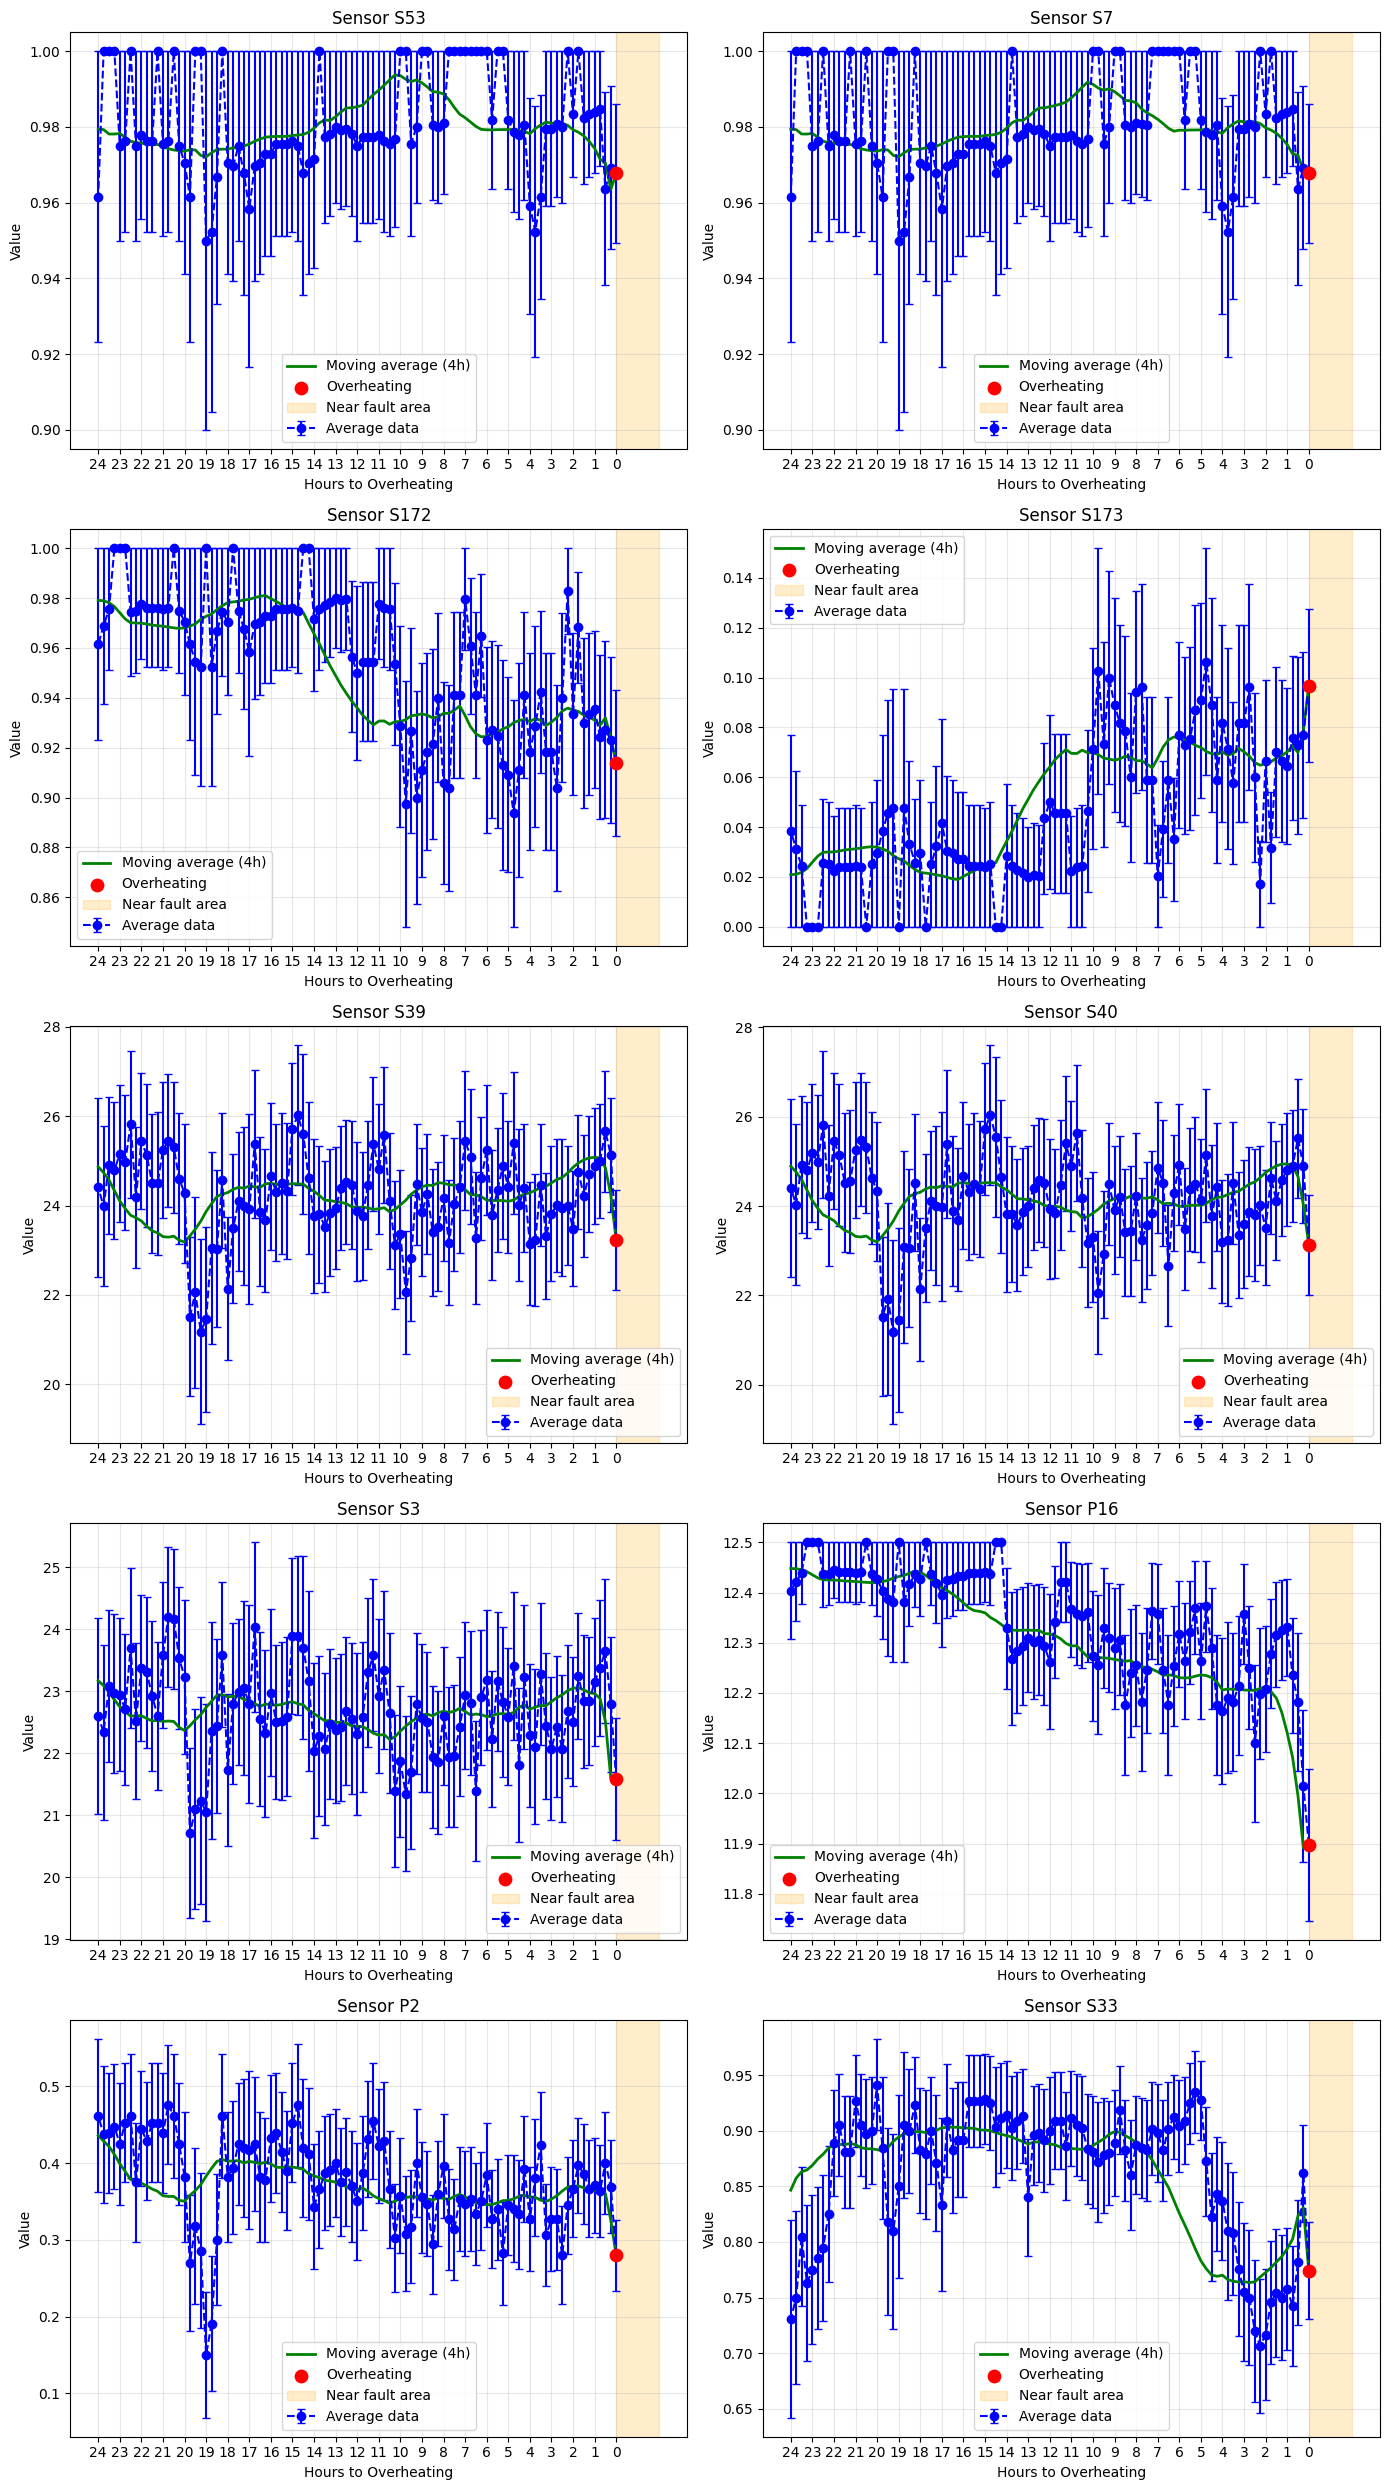

In [89]:
plot_overheating(pd_info_overheating, sensors, rolling_label="(4h)", show_minutes=1440, step_minutes=15, color="blue", area=["orange",-120,0])

Shows last 120 minutes with step=2


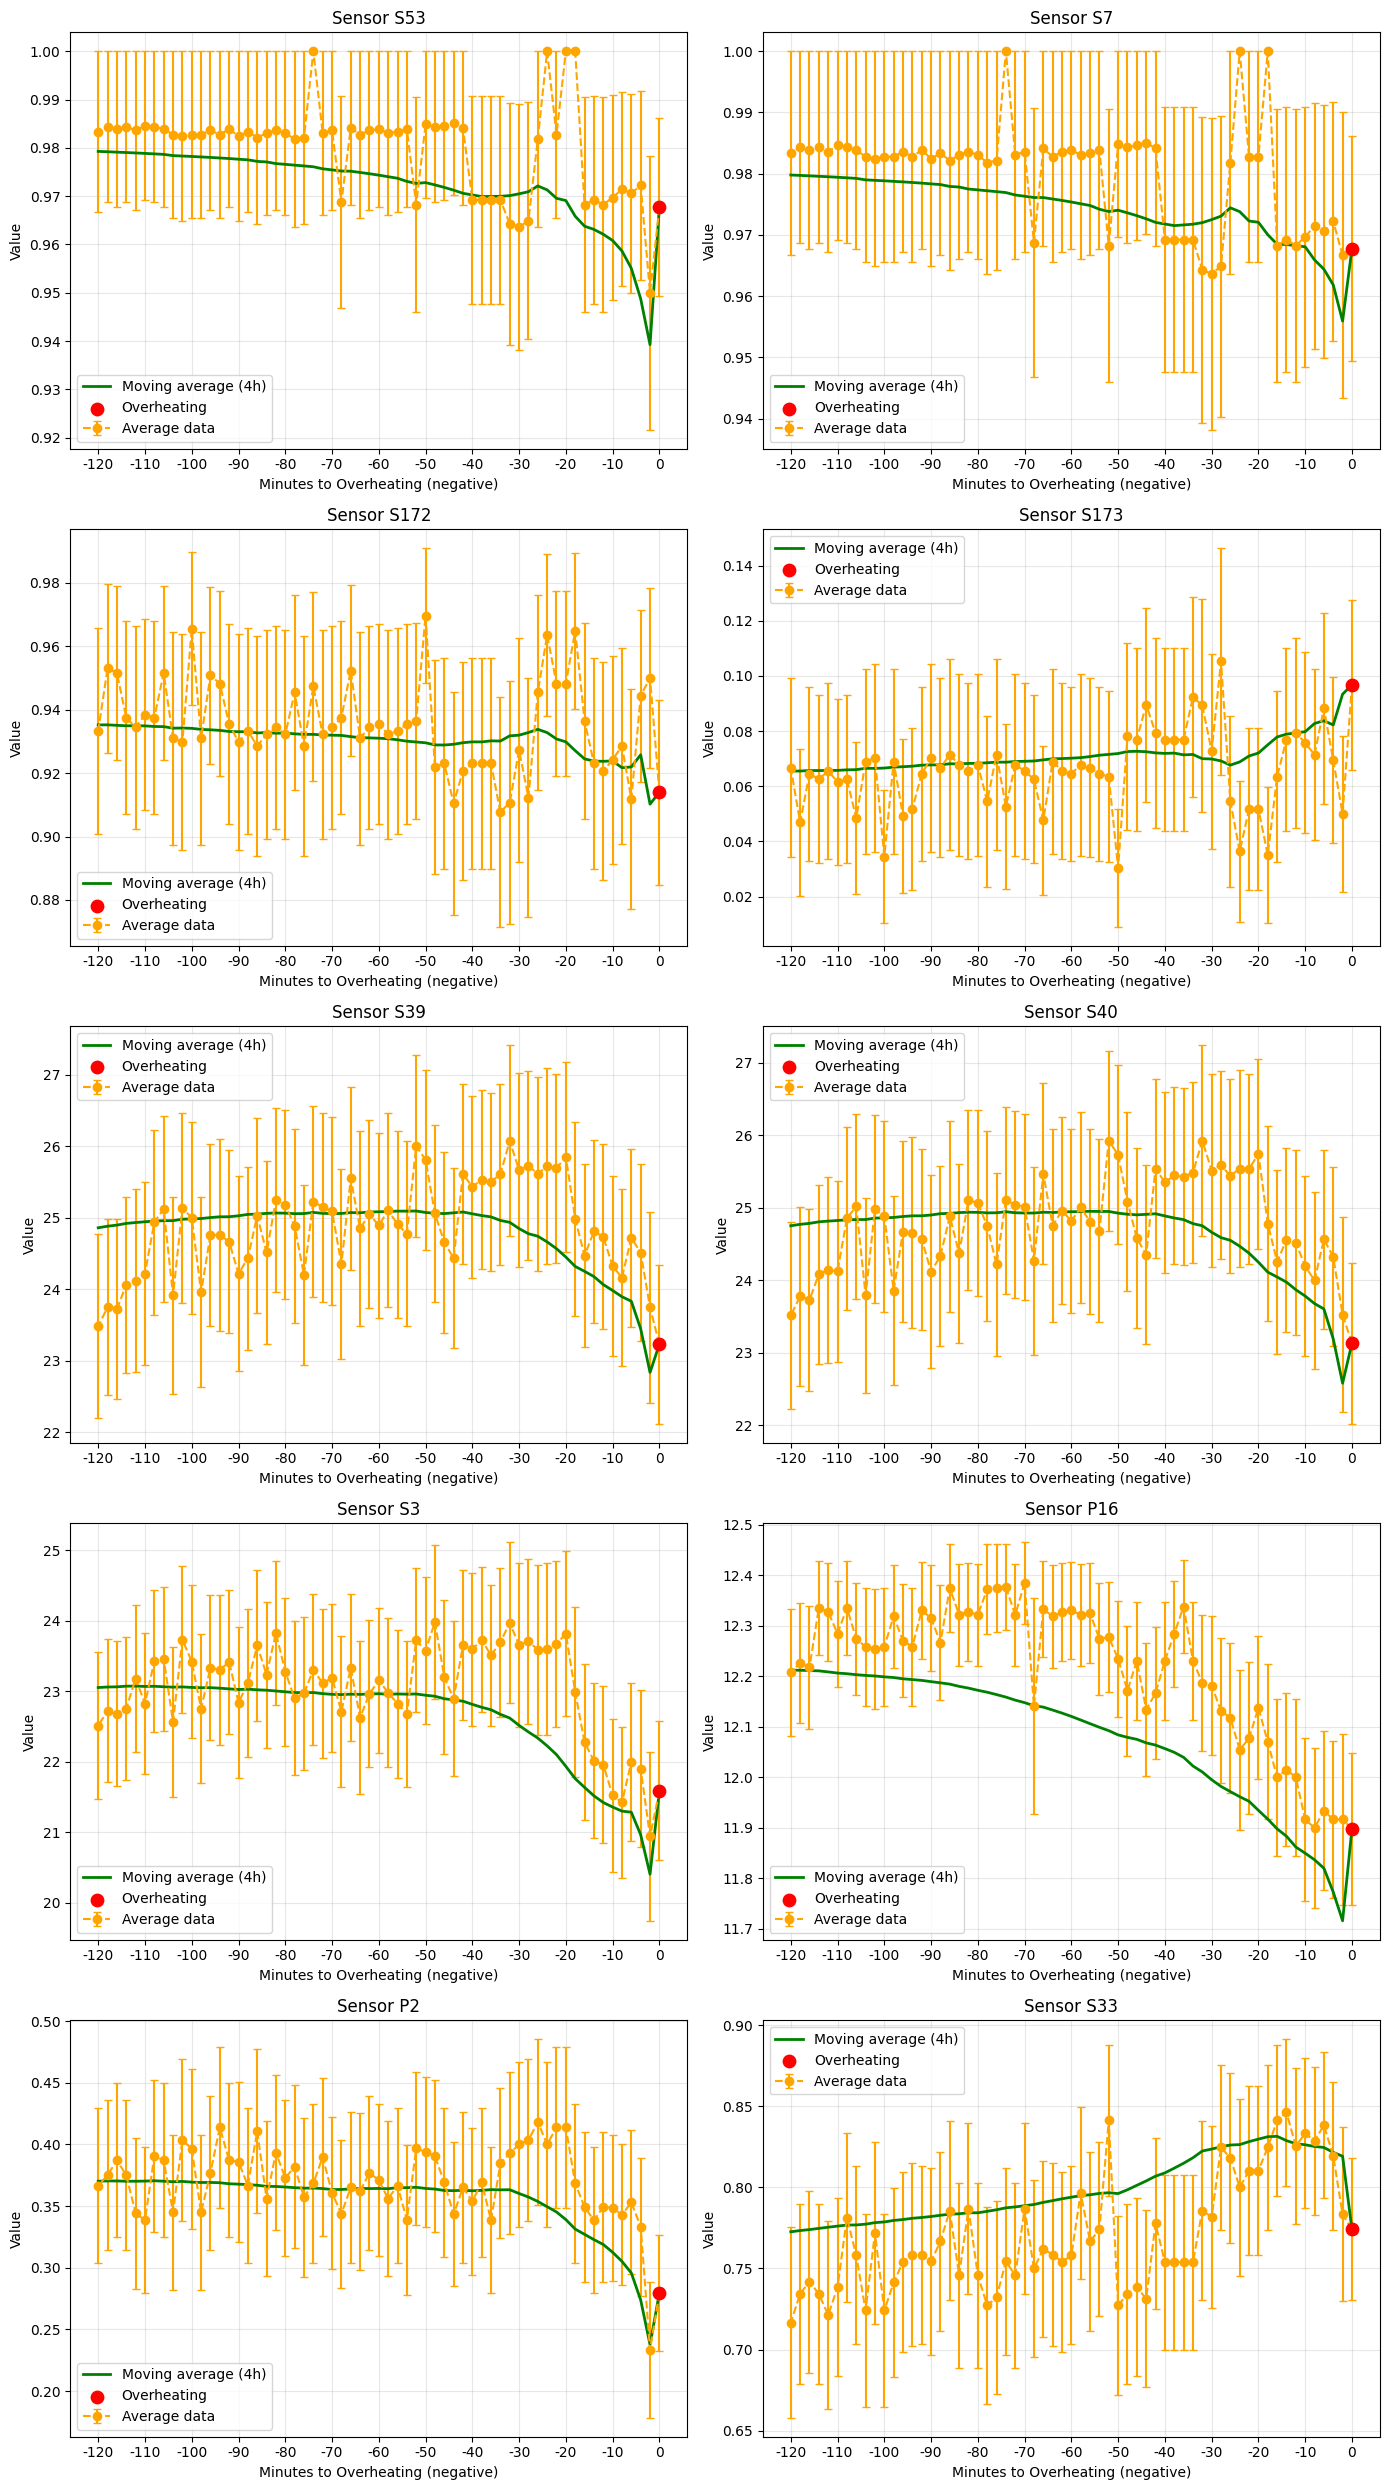

In [73]:
plot_overheating(pd_info_overheating, sensors, rolling_label="(4h)", show_minutes=120, step_minutes=2, color="orange")

# Calcolo derivate sensori

In [21]:
def add_rolling_and_derivative(df, colname, mean_minutes=6*60, debug = False): # 6*60 min = 6 h
    w = Window.partitionBy("BlockHeat").orderBy("when").rangeBetween(-mean_minutes*60, 0)
    w_all = Window.partitionBy("BlockHeat").orderBy("when")

    rolling_col = f"{colname}_rolling"
    rolling_prev = f"{colname}_rolling_prev"
    deriv_col = f"{colname}_rolling_derivative"

    df = df.withColumn(rolling_col, spark_avg(colname).over(w))
    df = df.withColumn(rolling_prev, lag(rolling_col).over(w_all))
    df = df.withColumn("when_prev", lag("when").over(w_all))
    df = df.withColumn( deriv_col, coalesce((col(rolling_col) - col(rolling_prev)) / (col("when") - col("when_prev")), lit(0)) )

    if debug:
        return df
    else:
        return df.drop(rolling_prev, "when_prev")

In [31]:
for s in sensors:
    df_maintenance = add_rolling_and_derivative(df_maintenance, s, mean_minutes=6*60, debug=True)

In [25]:
#controllo con il codice prima, sembra tutto ok

s = "S3"
# df_maintenance.filter("when>1617011230").select("when","window_start","overheating","predictive_overheating",s,f"{s}_rolling",f"{s}_rolling_prev",f"{s}_rolling_derivative")\
# .orderBy("when").show(3000)

df_maintenance.filter("predictive_overheating=1").select("when","window_start","overheating","predictive_overheating",s,f"{s}_rolling",f"{s}_rolling_prev",f"{s}_rolling_derivative")\
.orderBy("when").show(3000)

+----------+-------------------+-----------+----------------------+-----+------------------+------------------+---------------------+
|      when|       window_start|overheating|predictive_overheating|   S3|        S3_rolling|   S3_rolling_prev|S3_rolling_derivative|
+----------+-------------------+-----------+----------------------+-----+------------------+------------------+---------------------+
|1601510490|2020-10-01 00:01:00|          0|                     1| 12.5|              12.5|              NULL|                  0.0|
|1601510550|2020-10-01 00:02:00|          0|                     1| 12.5|              12.5|              12.5|                  0.0|
|1601510610|2020-10-01 00:03:00|          0|                     1| 12.5|              12.5|              12.5|                  0.0|
|1601510670|2020-10-01 00:04:00|          0|                     1| 12.5|              12.5|              12.5|                  0.0|
|1601595390|2020-10-01 23:36:00|          0|                  

## SVM, Logistic, RandomForest

In [58]:
from pyspark.ml.functions import vector_to_array

In [60]:
# ---------- Shared preprocessing ----------
def preprocess_features(df, feature_cols, scaler=True):
    df = df.where( (col(target) == 1) | ((col(target) == 0) & (rand(seed=123) <= 0.2)) )
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_feat = assembler.transform(df)\
            .select("BlockHeat","MinToOverheating",*feature_cols, *[c for c in df.columns if c not in feature_cols], "features")
    if not scaler:
        return df_feat, None
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
    scaler_model = scaler.fit(df_feat)
    df_scaled = scaler_model.transform(df_feat)
    return df_scaled, scaler_model

# ---------- SVM runner ----------
def svm(f_data, top_corr_alarm, target, weight_class1=1.0, seed=516622):
    
    df = f_data.select("BlockHeat","MinToOverheating",*top_corr_alarm, target)
    df_prep, scaler_model = preprocess_features(df, top_corr_alarm, scaler=True)
    df_prep = df_prep.withColumn("weight", when(col(target) == 1, lit(weight_class1)).otherwise(lit(1.0)))
    assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features_a")
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)
    
    svc = LinearSVC(featuresCol="features_a", labelCol=target,
                    rawPredictionCol="rawPrediction", predictionCol="prediction", weightCol="weight",
                    regParam=0.01, maxIter=1000, tol=1e-8)
    
    pipeline = Pipeline(stages=[assembler, svc]) #La pipeline serve per dire a Spark di eseguire due operazioni consecutive, poi Spark si arrangia a gestirle in questo modo

    model = pipeline.fit(train)
    
    preds = model.transform(df_prep)                          # predict on full (original) df_data
    preds = pred.withColumn("ProbOverheating", vector_to_array("probability")[1])
    cm = get_confusion_matrix(preds, target)
    plot_confusion_heatmap(cm, target)
    metrics = calculate_metrics(preds, cm, target)
    
    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "scaler": scaler_model}

# ---------- Random Forest runner (weigts_column) ----------
def random_forest(f_data, top_corr_alarm, target, weight_class1=1.0, n_trees=100, max_depth=10, seed=42):

    df = f_data.select("BlockHeat","MinToOverheating",*top_corr_alarm, target)
    df_prep, scaler_model = preprocess_features(df, top_corr_alarm, scaler=True)
    df_prep = df_prep.withColumn("weight", when(col(target) == 1, lit(weight_class1)).otherwise(lit(1.0)))
    assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="features_a")
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)

    rf = RandomForestClassifier(featuresCol="features_a", labelCol=target, weightCol="weight",  rawPredictionCol="rawPrediction",
        predictionCol="prediction", numTrees=n_trees, maxDepth=max_depth, seed=seed)

    pipeline = Pipeline(stages=[assembler, rf])
    model = pipeline.fit(train) 

    rf_model = model.stages[-1]
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(top_corr_alarm, importances), key=lambda x: -x[1])
    df_orig_prep, _ = preprocess_features(df, top_corr_alarm, scaler=False)
    
    preds = model.transform(df_orig_prep)
    preds = pred.withColumn("ProbOverheating", vector_to_array("probability")[1])
    cm = get_confusion_matrix(preds, target)
    plot_confusion_heatmap(cm, target)
    metrics = calculate_metrics(preds, cm, target)

    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "feature_importance": feature_importance}

# --------------------
def get_confusion_matrix(df_predictions, target):
    cm_data = df_predictions.groupBy(target, "prediction").count().collect()
    cm_dict = {(row[target], row["prediction"]): row['count'] for row in cm_data}   
    tn = cm_dict.get((0, 0), 0)
    fp = cm_dict.get((0, 1), 0)  
    fn = cm_dict.get((1, 0), 0)
    tp = cm_dict.get((1, 1), 0)
    return pd.DataFrame([[tn, fp], [fn, tp]], 
                       index=['Actual_0', 'Actual_1'],
                       columns=['Pred_0', 'Pred_1'])

# --------------------
def plot_confusion_heatmap(cm_pandas, target):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm_pandas, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.show()

# --------------------
def calculate_metrics(df_predictions, cm_pandas, target):
    tn, fp = cm_pandas.iloc[0]
    fn, tp = cm_pandas.iloc[1]
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=target)
    auc = evaluator.evaluate(df_predictions)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return {'accuracy': accuracy, 'precision': precision, 'auc': auc}

In [45]:
df = df_maintenance
rolling_means = [ f"{s}_rolling" for s in sensors ]
derivatives = [ f"{s}_rolling_derivative" for s in sensors ]
top_corr_alarm = rolling_means + derivatives #sensors + derivatives #messo volutamente sensors e no la media smussata

#previous
#df = df_final_088
#top_corr_alarm = ["S109","S9","S126"]
#top_corr_alarm = ["S7","S53","SA3","S8","S172","S173","S39","S40","S3","P2"] # per "predictive_overheating"

target = "predictive_overheating"
df_data = df.select("BlockHeat", "MinToOverheating",*top_corr_alarm,"overheating","predictive_overheating")

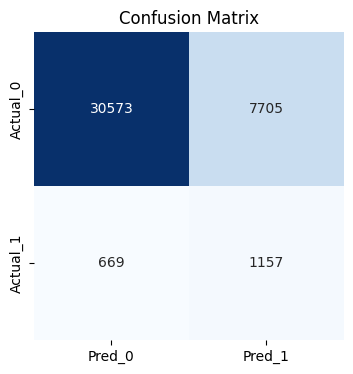

CPU times: user 90.8 ms, sys: 174 ms, total: 265 ms
Wall time: 1min 41s


In [39]:
%%time

# --------- SVM ---------
#svm(df_data, top_corr_alarm, target, weight_class1=7) # previous
Results_SVM = svm(df_data, top_corr_alarm, target, weight_class1=10)

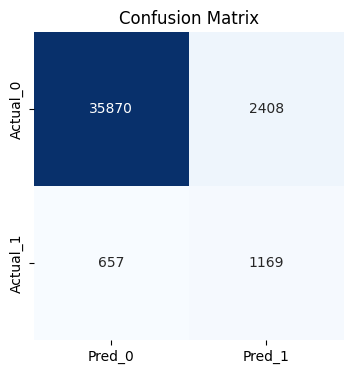

CPU times: user 312 ms, sys: 221 ms, total: 533 ms
Wall time: 3min 5s


In [46]:
%%time

# --------- Random Forest ---------
Results_RF = random_forest(df_data, top_corr_alarm, target, weight_class1=10 ,n_trees=300, max_depth=6)

#{"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "feature_importance": feature_importance}

In [47]:
Results_RF["predictions"].filter("predictive_overheating=1").select("BlockHeat","MinToOverheating","predictive_overheating","probability","prediction").show(300)

[Stage 50478:>                                                      (0 + 1) / 1]

+---------+----------------+----------------------+--------------------+----------+
|BlockHeat|MinToOverheating|predictive_overheating|         probability|prediction|
+---------+----------------+----------------------+--------------------+----------+
|        5|            30.0|                     1|[0.48902672065198...|       1.0|
|        5|            27.0|                     1|[0.48659556962984...|       1.0|
|        5|            26.0|                     1|[0.50119806761970...|       0.0|
|        5|            25.0|                     1|[0.49067229281124...|       1.0|
|        5|            24.0|                     1|[0.49067229281124...|       1.0|
|        5|            23.0|                     1|[0.49067229281124...|       1.0|
|        5|            22.0|                     1|[0.49067229281124...|       1.0|
|        5|            21.0|                     1|[0.49067229281124...|       1.0|
|        5|            20.0|                     1|[0.48824114178910...|    

In [62]:
Predictions_RF = Results_RF["predictions"]
Predictions_RF = Predictions_RF.withColumn("ProbOverheating", vector_to_array("probability")[1])

In [69]:
%%time

Porb_RF = Predictions_RF.groupBy("MinToOverheating").agg(spark_avg(col("ProbOverheating")).alias("AvgProb")).orderBy(col("MinToOverheating").desc())
            #.agg(spark_avg( lit(1.0)-col("probability") ).alias("prob_heating"))
pdf_Porb_RF =  Porb_RF.toPandas()                                                                                                              

CPU times: user 19.9 ms, sys: 5.25 ms, total: 25.1 ms
Wall time: 25.8 s


In [87]:
TwoDaysBefore

,MinToOverheating,AvgProb
22190,3775.0,0.180253
22191,3773.0,0.589092
22192,3772.0,0.180253
22193,3770.0,0.004195
22194,3768.0,0.281173
22195,3764.0,0.451258
22196,3763.0,0.451922
22197,3761.0,0.004195
22198,3759.0,0.356312
22199,3754.0,0.004195


In [ ]:
MinToOverheating = pdf_Porb_RF["MinToOverheating"].tolist()

In [83]:
# pd.set_option("display.max_rows", None)  # mostra tutte le righe
# pd.set_option("display.max_columns", None)  # mostra tutte le colonne
# TwoDaysBefore = pdf_Porb_RF.tail(2880)
# MinToOverheating = TwoDaysBefore["MinToOverheating"].tolist()

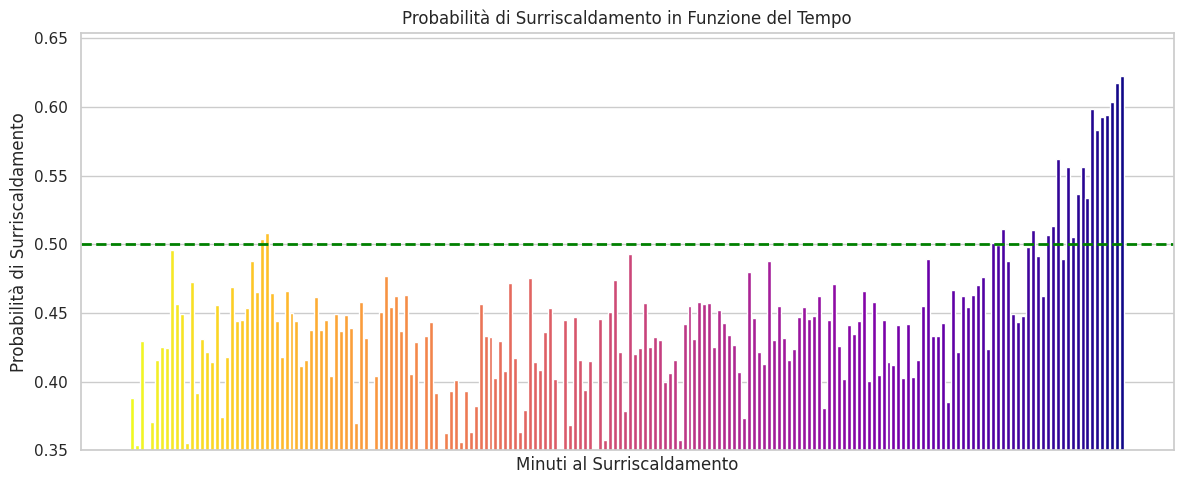

CPU times: user 239 ms, sys: 162 ms, total: 401 ms
Wall time: 180 ms


In [99]:
%%time

TwoDaysBefore = pdf_Porb_RF.tail(1000)
#MinToOverheating = TwoDaysBefore["MinToOverheating"].tolist()

# Parametri
step = 5        # ogni quanti dati disegnare una barra
tick_step = 30  # ogni quanti minuti mostrare un'etichetta sull'asse X

df_plot = TwoDaysBefore.iloc[::step].reset_index(drop=True)

# Normalizzazione colori su tutta la colonna MinToOverheating
norm = plt.Normalize(TwoDaysBefore["MinToOverheating"].min(),
                     TwoDaysBefore["MinToOverheating"].max())
colors = [plt.cm.plasma(norm(val)) for val in df_plot["MinToOverheating"]]

# Disegno barre
plt.figure(figsize=(12, 5))
plt.bar(
    x=np.arange(len(df_plot)),
    height=df_plot["AvgProb"],
    color=colors
)

plt.xlabel("Minuti al Surriscaldamento")
plt.ylabel("Probabilità di Surriscaldamento")
plt.title("Probabilità di Surriscaldamento in Funzione del Tempo")

# --- Gestione ticks personalizzati ---
# prendiamo solo i minuti multipli di tick_step
min_to_over = df_plot["MinToOverheating"].values
tick_positions = [i for i, val in enumerate(min_to_over) if val % tick_step == 0]
tick_labels = [min_to_over[i] for i in tick_positions]

plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

# Asse Y a partire da 0.35
plt.ylim(0.35, df_plot["AvgProb"].max() * 1.05)

# Show 0.5 threshold
plt.axhline(y=0.5, color='green', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

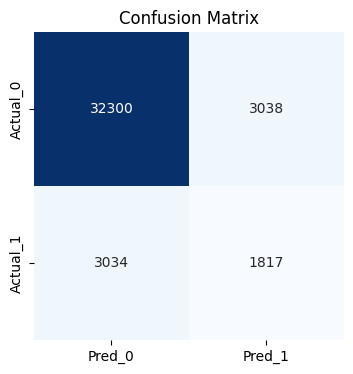

{'model': RandomForestClassificationModel: uid=RandomForestClassifier_69a74bb52f4c, numTrees=120, numClasses=2, numFeatures=10,
 'predictions': DataFrame[S7: int, S53: int, SA3: int, S8: int, S172: int, S173: int, S39: double, S40: double, S3: double, P2: int, flag_anomaly: int, features: vector, rawPrediction: vector, probability: vector, prediction: double],
 'cm':           Pred_0  Pred_1
 Actual_0   32300    3038
 Actual_1    3034    1817,
 'metrics': {'accuracy': 0.8489138819079848,
  'precision': 0.37425334706488156,
  'auc': 0.8120976927482267},
 'feature_importance': [('S40', 0.30019744370502005),
  ('S39', 0.2680522932556867),
  ('S3', 0.19732798591229256),
  ('S173', 0.08833664652623784),
  ('S172', 0.056383266336913526),
  ('S7', 0.036772209237197775),
  ('S53', 0.03139147480594331),
  ('S8', 0.010916806737363154),
  ('SA3', 0.009671730814711824),
  ('P2', 0.0009501426686332813)]}

In [40]:
%%time

# --------- Random Forest ---------
#previous version ---------------------- OCIO QUI ERA SBAGLIATO PERCHE' FLAG ANOMALY
random_forest(df_data, top_corr_alarm, "flag_anomaly", weight_class1=5, n_trees=300, max_depth=5)

## RandomTree (per singola variabile e poi combinato, sarebbe random forest ma vista step by step)

In [116]:
def get_best_threshold(df, feature, target):

    df = df.where( (col(target) == 1) | ((col(target) == 0) & (rand(seed=seed) <= 0.2)) )
    
    assembler = VectorAssembler(inputCols=[feature], outputCol="features")
    df_vec = assembler.transform(df)
    
    dt = DecisionTreeClassifier(featuresCol="features", labelCol=target, maxDepth=1)
    model = dt.fit(df_vec)
    
    # parsing dello split
    tree_str = model.toDebugString
    for line in tree_str.splitlines():
        if "<=" in line:
            try:
                return float(line.split("<= ")[1].split()[0])
            except:
                pass
    
    # fallback: media delle mediane
    medians = (
        df.groupBy(target)
          .agg(F.expr(f"percentile_approx({feature}, 0.5)").alias("median"))
          .toPandas()
    )
    if len(medians) == 2:
        return medians["median"].mean()
    else:
        return float(medians["median"].iloc[0])  # caso raro: solo una classe presente

In [117]:
def plot_histograms_with_threshold(df_spark, target_col, feature_cols, thresholds):
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # histogram per classi
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        # soglia verticale tratteggiata (solo se esiste)
        thr = thresholds.get(feature, None)
        if thr is not None:
            ax.axvline(x=thr, color="black", linestyle="--", linewidth=2, label="Threshold")
        
        ax.set_ylabel("Density")
        ax.set_xlabel(feature)
        ax.legend()
        
        fig.suptitle(f"{feature}")
        plt.tight_layout()
        plt.show()

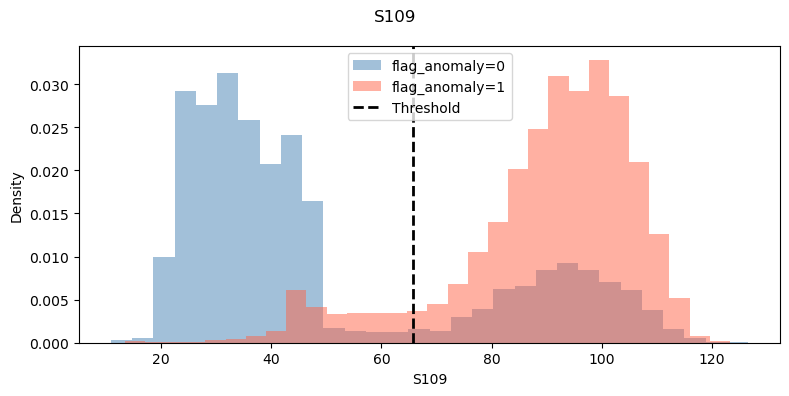

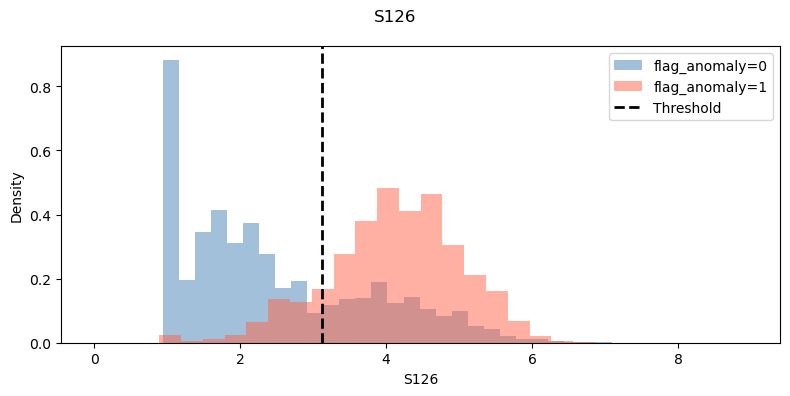

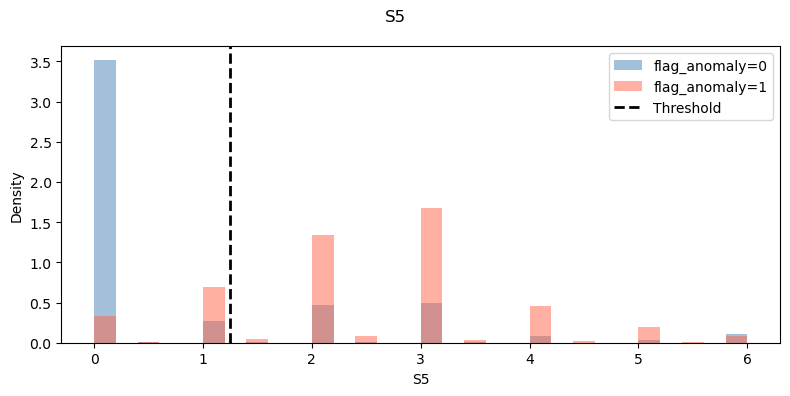

CPU times: user 491 ms, sys: 20 ms, total: 511 ms
Wall time: 1min 16s


In [118]:
%%time

thresholds = {}
for feature in ["S109","S126","S5"]:
    thr = get_best_threshold(df_final_088, feature, target="flag_anomaly")
    thresholds[feature] = thr

plot_histograms_with_threshold(df_final_088, "flag_anomaly", ["S109","S126","S5"], thresholds)